# Final Project Jupyter Notebook

## Relationships Between Youth Smoking Prevalences, Tobacco Sales, and Other Socio-Demographic Variables

Group Members: Rida Abdulwasay, Bakar Haghighi, Daniel Jang, Saumya Sharma


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import operator
import math
import itertools
import collections
import nltk
import plotly.express as px
import warnings
import statsmodels.api as sm
import itertools
from ipywidgets import interact, interactive
import statsmodels
import hashlib
import matplotlib.pyplot as plt
import random
import time
import scipy as sc
import statsmodels.stats.power as smp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR

sns.set(style="dark")
plt.style.use("ggplot")
%matplotlib inline

In [2]:
random.seed(1234)
np.random.seed(1234)

# Loading Data & Cleaning It

Here, we read in all th csv files needed that contain the data relevant to our research question

In [3]:
### Tobacco
tobacco = pd.read_csv("U.S._Chronic_Disease_Indicators__Tobacco.csv")

# find list of columns with only null values so we can drop them
null_cols = tobacco.isna().sum().to_frame().reset_index().rename(columns={0: "null"})
drop_cols = null_cols[null_cols["null"] == len(tobacco)]["index"]
tobacco = tobacco.drop(columns=drop_cols)

### Excise Tax
excise_tax = tobacco[tobacco["Question"] == "Amount of tobacco product excise tax"]
excise_tax["DataValue"] = excise_tax["DataValue"].replace({"Yes": 1, "No": 0})


new_df = excise_tax[["YearStart", "LocationAbbr", "LocationDesc", "DataValue"]].rename(columns=
                                                                                       {"YearStart": "year",
                                                                                        "LocationAbbr": "state",
                                                                                       "DataValue": "excise_tax"})
new_df = new_df.sort_values(by="year")

#### Crude Prevalence
crude_prevalence = tobacco[tobacco["Question"] == "Current cigarette smoking among youth"]
crude_prevalence["DataValue"] = crude_prevalence["DataValue"].astype(float)

crude_prevalence = crude_prevalence.drop(columns=["LocationID", "StratificationID1",
                                                  "TopicID", "QuestionID", "DataValueTypeID",
                                                 "YearEnd", "DataValueFootnoteSymbol", 
                                                 "StratificationCategoryID1",
                                                 "Topic"])


crude_prevalence = crude_prevalence[~crude_prevalence["DataValue"].isna()]


##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### ##### 

youth_prevalence = crude_prevalence[["YearStart", "LocationAbbr", "LocationDesc", 
                                     "DataValue",
                                    "Stratification1"]].rename(columns={"YearStart": "year",
                                                                                        "LocationAbbr": "state",
                                                                                       "DataValue": "prevalence_percent"})
youth = youth_prevalence[youth_prevalence["Stratification1"] == "Overall"]

## Per Capita Sales
per_capita_sales = tobacco[tobacco["Question"] == "Sale of cigarette packs"]
per_capita_sales = per_capita_sales.rename(columns={"YearStart": "year", "DataValue": "avg_sales_per_capita",})
per_capita_sales = per_capita_sales[["year", "LocationDesc", "avg_sales_per_capita"]]
per_capita_sales = per_capita_sales.dropna()
per_capita_sales = per_capita_sales.groupby(["year", "LocationDesc"]).mean().reset_index()
per_capita_sales

# EXTERNAL DATASET #1 - Median Income
median_income = pd.read_csv("median_income.csv")

cols_drop = median_income.columns[median_income.columns.str.contains("Standard")]
median_income = median_income.drop(columns=cols_drop).set_index("Location")
median_income.head()

/var/folders/hg/_t5rxvbs7_g35c90gp34frmh0000gn/T/ipykernel_75754/1595401627.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tobacco = pd.read_csv("U.S._Chronic_Disease_Indicators__Tobacco.csv")
/var/folders/hg/_t5rxvbs7_g35c90gp34frmh0000gn/T/ipykernel_75754/1595401627.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excise_tax["DataValue"] = excise_tax["DataValue"].replace({"Yes": 1, "No": 0})
/var/folders/hg/_t5rxvbs7_g35c90gp34frmh0000gn/T/ipykernel_75754/1595401627.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

2021 Median income 2020 Median income 2019 Median income  \
Location                                                                 
United States             70,784             68,010             68,703   
Alabama                   56,929             54,689             56,200   
Alaska                    81,133             74,746             78,394   
Arizona                   70,821             67,088             70,674   
Arkansas                  50,784             50,777             54,539   

              2018 Median income 2017(40) Median income 2017 Median income  \
Location                                                                     
United States             63,179                 61,136             61,372   
Alabama                   49,936                 50,865             51,113   
Alaska                    68,734                 77,987             72,231   
Arizona                   62,283                 59,700             61,125   
Arkansas                  49,781                 49,751             48,829   

              2016 Median income 2015 Median income 2014 Median income  \
Location                                                                 
United States             59,039             56,516             53,657   
Alabama                   47,221             44,509             42,278   
Alaska                    75,723             75,112             67,629   
Arizona                   57,100             52,248             49,254   
Arkansas                  45,907             42,798             44,922   

              2013 (39) Median income 2013 (38) Median income  
Location                                                       
United States                  53,585                  51,939  
Alabama                        47,320                  41,381  
Alaska                         72,472                  61,137  
Arizona                        52,611                  50,602  
Arkansas                       39,376                  39,919

In [4]:
## Useful Dicts
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

president_dict = {2013 : "Barack Obama",
                  2017 : "Trump",
                  2019: "Trump",
}

party_dict = { 2013: "Democrat",
                2017 : "Republican",
                  2019 : "Republican",
}

# Regions are based off of those at
# http://nationalgeographic.org/maps/united-states-regions/
# Because those made more sense to me than the census regions
# https://gist.github.com/sfirrin/fd01d87f022d80e98c37a045c14109fe

states_to_regions = {
    'Washington': 'West', 'Oregon': 'West', 'California': 'West', 'Nevada': 'West',
    'Idaho': 'West', 'Montana': 'West', 'Wyoming': 'West', 'Utah': 'West',
    'Colorado': 'West', 'Alaska': 'West', 'Hawaii': 'West', 'Maine': 'Northeast',
    'Vermont': 'Northeast', 'New York': 'Northeast', 'New Hampshire': 'Northeast',
    'Massachusetts': 'Northeast', 'Rhode Island': 'Northeast', 'Connecticut': 'Northeast',
    'New Jersey': 'Northeast', 'Pennsylvania': 'Northeast', 'North Dakota': 'Midwest',
    'South Dakota': 'Midwest', 'Nebraska': 'Midwest', 'Kansas': 'Midwest',
    'Minnesota': 'Midwest', 'Iowa': 'Midwest', 'Missouri': 'Midwest', 'Wisconsin': 'Midwest',
    'Illinois': 'Midwest', 'Michigan': 'Midwest', 'Indiana': 'Midwest', 'Ohio': 'Midwest',
    'West Virginia': 'South', 'District of Columbia': 'South', 'Maryland': 'South',
    'Virginia': 'South', 'Kentucky': 'South', 'Tennessee': 'South', 'North Carolina': 'South',
    'Mississippi': 'South', 'Arkansas': 'South', 'Louisiana': 'South', 'Alabama': 'South',
    'Georgia': 'South', 'South Carolina': 'South', 'Florida': 'South', 'Delaware': 'South',
    'Arizona': 'Southwest', 'New Mexico': 'Southwest', 'Oklahoma': 'Southwest',
    'Texas': 'Southwest'}

annual_resident_pop = pd.read_csv("annual_resident_pop.csv", skiprows=1)
annual_resident_pop = annual_resident_pop.rename(columns={'Unnamed: 0': 'State'})
annual_resident_pop["State"] = annual_resident_pop["State"].str.replace('.', '')
annual_resident_pop = annual_resident_pop.replace(',','', regex=True)
annual_resident_pop.iloc[:,1:] = annual_resident_pop.iloc[:,1:].astype(float)

column_names = list(annual_resident_pop.columns)
for i in range(3,len(column_names)):
    column_names[i] = "Population Estimate " + column_names[i]
annual_resident_pop.columns = column_names
annual_resident_pop = annual_resident_pop.dropna()

##########################################################
hs = pd.read_csv("highschool_dropout_rates.csv")
hs = hs[['State', '2013', '2017', '2019']]
hs = hs.rename(columns={'State':'LocationDesc'})

##########################################################
# Teen Birth Rate per 1,000 Population Ages 15-19
# https://www.kff.org/other/state-indicator/teen-birth-rate-per-1000/?currentTimeframe=8&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D
teen_birth_rate = pd.read_csv("num_birth.csv").rename(columns={"Location": "LocationDesc"})

##########################################################
#https://www.kff.org/other/state-indicator/distribution-by-sex/?currentTimeframe=7&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D
gender_ratio = pd.read_csv("gender_ratio.csv").rename(columns={"Location": "LocationDesc"})


/var/folders/hg/_t5rxvbs7_g35c90gp34frmh0000gn/T/ipykernel_75754/2010046869.py:96: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  annual_resident_pop["State"] = annual_resident_pop["State"].str.replace('.', '')


# Merge Datasets

Here, we merge dataframes to extract relevant information in a more accessable manner

In [5]:
# Merge Youth Crude Prevalence
dd = youth.merge(new_df, left_on = ["year", "state", "LocationDesc"], right_on = ["year", "state", "LocationDesc"], how = "outer") # double check if merged right!!

# Merge Median Income
df0 = dd.merge(median_income, left_on="LocationDesc", right_on="Location", how = "outer").drop(columns={"Stratification1"})

# Merge Annual Population
df1 = df0.merge(annual_resident_pop, left_on="LocationDesc", right_on="State", how = "outer")

df = df1.dropna()

new_df = pd.DataFrame()

all_years = list(df["year"].unique())
all_years

for year in all_years:
    temp_df = df.copy()
    temp_df = temp_df[temp_df["year"]==year]
    temp_df = temp_df.iloc[:,0:5]
    if (year != 2013) and (year != 2017):
        temp_df["Population Estimate"] = df["Population Estimate " + str(int(year)) ]
        temp_df["Median income"] = df[str(int(year)) + " Median income"].str.replace(',', '').astype(float)
        temp_df["Median income v1"] =  df[str(int(year)) + " Median income"].str.replace(',', '').astype(float)
        temp_df["Median income v2"] = 0
    elif year == 2013:
        temp_df["Population Estimate"] = df["Population Estimate " + str(int(year)) ]
        temp_df["Median income v1"] = df[str(int(year)) + " (38) Median income"].str.replace(',', '').astype(float)
        temp_df["Median income v2"] = df[str(int(year)) + " (39) Median income"].str.replace(',', '').astype(float)
        temp_df["Median income"] = (temp_df["Median income v1"]+ temp_df["Median income v2"])/2
    elif year == 2017:
        temp_df["Population Estimate"] = df["Population Estimate " + str(int(year)) ]
        temp_df["Median income v1"] = df[str(int(year)) + " Median income"].str.replace(',', '').astype(float)
        temp_df["Median income v2"] = df[str(int(year)) + "(40) Median income"].str.replace(',', '').astype(float)
        temp_df["Median income"] = (temp_df["Median income v1"]+ temp_df["Median income v2"])/2
    new_df = pd.concat([new_df, temp_df])
    
new_df = new_df.drop(columns={"Median income v1", "Median income v2"})
new_df

new_new_df = new_df.copy()
#new_new_df = new_new_df.set_index(["year", "LocationDesc"])
new_new_df


df2 = new_new_df.merge(per_capita_sales, left_on=["year", "LocationDesc"], right_on=["year", "LocationDesc"])
df2["us_overall_party"] = df2["year"].replace(party_dict)
df2["income_above_50k"] = (df2["Median income"] > 50000).astype(int)



def income_buckets(x):
    if x < 10000:
        return "less than 10k"
    elif x <= 25000: 
        return "between 10k to 25k"  
    elif x <= 50000: 
        return "between 25k to 50k"  
    
    elif x <= 75000: 
        return "between 50k to 75k"  
    elif x <= 100000: 
        return "between 75k to 100k"  
    else:
        return "over 100k"
    
df2["income_bucket"] = df2["Median income"].apply(income_buckets)
df2["Population Estimate"] = df2["Population Estimate"].astype(float)
df2 = df2.merge(hs)

df2["hs_dropout_rate"] = np.arange(0, len(df2)) # dummy values

# Update DataFrame to match correct hs_dropout rate

for index, row in df2.iterrows():
    # update the row in the dataframe
    if row["year"] == 2013:
        df2['hs_dropout_rate'].at[index] = df2['2013'].at[index]

    if row["year"] == 2017:
        df2['hs_dropout_rate'].at[index] = df2['2017'].at[index]

    if row["year"] == 2019:
        df2['hs_dropout_rate'].at[index] = df2['2019'].at[index]
    
df2 = df2.drop(columns={"2013", "2017", "2019"})


df2 = df2.merge(teen_birth_rate, left_on="LocationDesc", right_on="LocationDesc")
df2["teen_birth_rate"] = np.arange(0, len(df2)) # dummy values

for index, row in df2.iterrows():
    # update the row in the dataframe
    if row["year"] == 2013:
        df2['teen_birth_rate'].at[index] = df2['2013'].at[index]

    if row["year"] == 2017:
        df2['teen_birth_rate'].at[index] = df2['2017'].at[index]

    if row["year"] == 2019:
        df2['teen_birth_rate'].at[index] = df2['2019'].at[index]
    
    
df2["region"] = df2["LocationDesc"].replace(states_to_regions)

# arbitrarily number them
df2["region_number"] = df2["region"].replace({"Midwest" : 0, 
                            "Northeast" : 1,
                            "South" : 2,
                            "Southwest" : 3,
                            "West" : 4,})


df2 = df2.drop(columns={"2013", "2017", "2019"})


###############################################################################################

new_df = pd.DataFrame()

all_years = list(df["year"].unique())
all_years

for year in all_years:
    temp_df = df.copy()
    temp_df = temp_df[temp_df["year"]==year]
    temp_df = temp_df.iloc[:,0:5]
    if (year != 2013) and (year != 2017):
        temp_df["Population Estimate"] = df["Population Estimate " + str(int(year)) ]
        temp_df["Median income"] = df[str(int(year)) + " Median income"].str.replace(',', '').astype(float)
        temp_df["Median income v1"] =  df[str(int(year)) + " Median income"].str.replace(',', '').astype(float)
        temp_df["Median income v2"] = 0
    elif year == 2013:
        temp_df["Population Estimate"] = df["Population Estimate " + str(int(year)) ]
        temp_df["Median income v1"] = df[str(int(year)) + " (38) Median income"].str.replace(',', '').astype(float)
        temp_df["Median income v2"] = df[str(int(year)) + " (39) Median income"].str.replace(',', '').astype(float)
        temp_df["Median income"] = (temp_df["Median income v1"]+ temp_df["Median income v2"])/2
    elif year == 2017:
        temp_df["Population Estimate"] = df["Population Estimate " + str(int(year)) ]
        temp_df["Median income v1"] = df[str(int(year)) + " Median income"].str.replace(',', '').astype(float)
        temp_df["Median income v2"] = df[str(int(year)) + "(40) Median income"].str.replace(',', '').astype(float)
        temp_df["Median income"] = (temp_df["Median income v1"]+ temp_df["Median income v2"])/2
    new_df = pd.concat([new_df, temp_df])
    
new_df = new_df.drop(columns={"Median income v1", "Median income v2"})
new_df

new_new_df = new_df.copy()
#new_new_df = new_new_df.set_index(["year", "LocationDesc"])
new_new_df


df2 = new_new_df.merge(per_capita_sales, left_on=["year", "LocationDesc"], right_on=["year", "LocationDesc"])
df2["us_overall_party"] = df2["year"].replace(party_dict)
df2["income_above_50k"] = (df2["Median income"] > 50000).astype(int)


def income_buckets(x):
    if x < 10000:
        return "less than 10k"
    elif x <= 25000: 
        return "between 10k to 25k"  
    elif x <= 50000: 
        return "between 25k to 50k"  
    
    elif x <= 75000: 
        return "between 50k to 75k"  
    elif x <= 100000: 
        return "between 75k to 100k"  
    else:
        return "over 100k"
    
df2["income_bucket"] = df2["Median income"].apply(income_buckets)
df2["Population Estimate"] = df2["Population Estimate"].astype(float)
df2 = df2.merge(hs)

df2["hs_dropout_rate"] = np.arange(0, len(df2)) # dummy values

# Update DataFrame to match correct hs_dropout rate

for index, row in df2.iterrows():
    # update the row in the dataframe
    if row["year"] == 2013:
        df2['hs_dropout_rate'].at[index] = df2['2013'].at[index]

    if row["year"] == 2017:
        df2['hs_dropout_rate'].at[index] = df2['2017'].at[index]

    if row["year"] == 2019:
        df2['hs_dropout_rate'].at[index] = df2['2019'].at[index]
    
df2 = df2.drop(columns={"2013", "2017", "2019"})


df2 = df2.merge(teen_birth_rate, left_on="LocationDesc", right_on="LocationDesc")
df2["teen_birth_rate"] = np.arange(0, len(df2)) # dummy values

for index, row in df2.iterrows():
    # update the row in the dataframe
    if row["year"] == 2013:
        df2['teen_birth_rate'].at[index] = df2['2013'].at[index]

    if row["year"] == 2017:
        df2['teen_birth_rate'].at[index] = df2['2017'].at[index]

    if row["year"] == 2019:
        df2['teen_birth_rate'].at[index] = df2['2019'].at[index]
    
    
df2["region"] = df2["LocationDesc"].replace(states_to_regions)

# arbitrarily number them
df2["region_number"] = df2["region"].replace({"Midwest" : 0, 
                            "Northeast" : 1,
                            "South" : 2,
                            "Southwest" : 3,
                            "West" : 4,})

df2 = df2.drop(columns={"2013", "2017", "2019"})
df2.head()

df2.head()

year state LocationDesc  prevalence_percent  excise_tax  \
0  2013    WY      Wyoming                17.4         0.0   
1  2013    NY     New York                10.6         1.0   
2  2017    NY     New York                 5.5         0.0   
3  2019    NY     New York                 4.2         0.0   
4  2013    OH         Ohio                15.1         0.0   

   Population Estimate  Median income  avg_sales_per_capita us_overall_party  \
0             582122.0        61570.5                  60.8         Democrat   
1           19624447.0        51904.5                  16.6         Democrat   
2           19589572.0        61995.0                  13.3       Republican   
3           19453561.0        71855.0                  11.7       Republican   
4           11576684.0        48573.0                  54.6         Democrat   

   income_above_50k       income_bucket  hs_dropout_rate  teen_birth_rate  \
0                 1  between 50k to 75k              6.2             29.6   
1                 1  between 50k to 75k              6.6             17.7   
2                 1  between 50k to 75k              5.0             12.5   
3                 1  between 50k to 75k             12.6             11.4   
4                 0  between 25k to 50k              6.1             27.2   

      region  region_number  
0       West              4  
1  Northeast              1  
2  Northeast              1  
3  Northeast              1  
4    Midwest              0

In [6]:
new_df = pd.DataFrame()

all_years = list(df["year"].unique())
all_years

for year in all_years:
    temp_df = df.copy()
    temp_df = temp_df[temp_df["year"]==year]
    temp_df = temp_df.iloc[:,0:5]
    if (year != 2013) and (year != 2017):
        temp_df["Population Estimate"] = df["Population Estimate " + str(int(year)) ]
        temp_df["Median income"] = df[str(int(year)) + " Median income"].str.replace(',', '').astype(float)
        temp_df["Median income v1"] =  df[str(int(year)) + " Median income"].str.replace(',', '').astype(float)
        temp_df["Median income v2"] = 0
    elif year == 2013:
        temp_df["Population Estimate"] = df["Population Estimate " + str(int(year)) ]
        temp_df["Median income v1"] = df[str(int(year)) + " (38) Median income"].str.replace(',', '').astype(float)
        temp_df["Median income v2"] = df[str(int(year)) + " (39) Median income"].str.replace(',', '').astype(float)
        temp_df["Median income"] = (temp_df["Median income v1"]+ temp_df["Median income v2"])/2
    elif year == 2017:
        temp_df["Population Estimate"] = df["Population Estimate " + str(int(year)) ]
        temp_df["Median income v1"] = df[str(int(year)) + " Median income"].str.replace(',', '').astype(float)
        temp_df["Median income v2"] = df[str(int(year)) + "(40) Median income"].str.replace(',', '').astype(float)
        temp_df["Median income"] = (temp_df["Median income v1"]+ temp_df["Median income v2"])/2
    new_df = pd.concat([new_df, temp_df])
    
new_df = new_df.drop(columns={"Median income v1", "Median income v2"})
new_df

new_new_df = new_df.copy()
#new_new_df = new_new_df.set_index(["year", "LocationDesc"])
new_new_df


df2 = new_new_df.merge(per_capita_sales, left_on=["year", "LocationDesc"], right_on=["year", "LocationDesc"])
df2["us_overall_party"] = df2["year"].replace(party_dict)
df2["income_above_50k"] = (df2["Median income"] > 50000).astype(int)


def income_buckets(x):
    if x < 10000:
        return "less than 10k"
    elif x <= 25000: 
        return "between 10k to 25k"  
    elif x <= 50000: 
        return "between 25k to 50k"  
    
    elif x <= 75000: 
        return "between 50k to 75k"  
    elif x <= 100000: 
        return "between 75k to 100k"  
    else:
        return "over 100k"
    
df2["income_bucket"] = df2["Median income"].apply(income_buckets)
df2["Population Estimate"] = df2["Population Estimate"].astype(float)
df2 = df2.merge(hs)

df2["hs_dropout_rate"] = np.arange(0, len(df2)) # dummy values

# Update DataFrame to match correct hs_dropout rate

for index, row in df2.iterrows():
    # update the row in the dataframe
    if row["year"] == 2013:
        df2['hs_dropout_rate'].at[index] = df2['2013'].at[index]

    if row["year"] == 2017:
        df2['hs_dropout_rate'].at[index] = df2['2017'].at[index]

    if row["year"] == 2019:
        df2['hs_dropout_rate'].at[index] = df2['2019'].at[index]
    
df2 = df2.drop(columns={"2013", "2017", "2019"})


df2 = df2.merge(teen_birth_rate, left_on="LocationDesc", right_on="LocationDesc")
df2["teen_birth_rate"] = np.arange(0, len(df2)) # dummy values

for index, row in df2.iterrows():
    # update the row in the dataframe
    if row["year"] == 2013:
        df2['teen_birth_rate'].at[index] = df2['2013'].at[index]

    if row["year"] == 2017:
        df2['teen_birth_rate'].at[index] = df2['2017'].at[index]

    if row["year"] == 2019:
        df2['teen_birth_rate'].at[index] = df2['2019'].at[index]
    
    
df2["region"] = df2["LocationDesc"].replace(states_to_regions)

# arbitrarily number them
df2["region_number"] = df2["region"].replace({"Midwest" : 0, 
                            "Northeast" : 1,
                            "South" : 2,
                            "Southwest" : 3,
                            "West" : 4,})


df2 = df2.drop(columns={"2013", "2017", "2019"})


#######

cols_to_use = gender_ratio.columns.difference(df2.columns)
cols_to_use

#https://www.kff.org/other/state-indicator/distribution-by-raceethnicity/?currentTimeframe=7&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D
prop_white = pd.read_csv("prop_white.csv").rename(columns={"Location": "LocationDesc"})
df2 = df2.merge(prop_white)

df2["White_Prop"] = np.arange(0, len(df2))

for index, row in df2.iterrows():
    # update the row in the dataframe
    if row["year"] == 2013:
        df2['White_Prop'].at[index] = df2['White_2013'].at[index]

    if row["year"] == 2017:
        df2['White_Prop'].at[index] = df2['White_2017'].at[index]
        
    if row["year"] == 2019:
        df2['White_Prop'].at[index] = df2['White_2019'].at[index]

df2 = df2.drop(columns={"White_2013",
                       "White_2017", "White_2019"})


########

df2 = df2.merge(gender_ratio)

df2["Male_Percent"] = np.arange(0, len(df2))
df2["Female_Percent"] = np.arange(0, len(df2))

for index, row in df2.iterrows():
    # update the row in the dataframe
    if row["year"] == 2013:
        df2['Male_Percent'].at[index] = df2['Male_2013'].at[index]
        df2['Female_Percent'].at[index] = df2['Female_2013'].at[index]

    if row["year"] == 2017:
        df2['Male_Percent'].at[index] = df2['Male_2017'].at[index]
        df2['Female_Percent'].at[index] = df2['Female_2017'].at[index]

    if row["year"] == 2019:
        df2['Male_Percent'].at[index] = df2['Male_2019'].at[index]
        df2['Female_Percent'].at[index] = df2['Female_2019'].at[index]

df2 = df2.drop(columns={"Male_2013", "Female_2013", "Male_2017", "Female_2017",
                       "Male_2019", "Female_2019"})

###############

adults_with_children = pd.read_csv("adults_with_children.csv").rename(columns={"Location": "LocationDesc"})
df2 = df2.merge(adults_with_children)


df2["prop_adults_with_children"] = np.arange(0, len(df2))

for index, row in df2.iterrows():
    # update the row in the dataframe
    if row["year"] == 2013:
        df2['prop_adults_with_children'].at[index] = df2['prop_2013'].at[index]

    if row["year"] == 2017:
        df2['prop_adults_with_children'].at[index] = df2['prop_2017'].at[index]
        
    if row["year"] == 2019:
        df2['prop_adults_with_children'].at[index] = df2['prop_2019'].at[index]

df2 = df2.drop(columns={"prop_2013",
                       "prop_2017", "prop_2019"})



# https://www.britannica.com/place/the-West-region-United-States
######
###
df2.head()

year state LocationDesc  prevalence_percent  excise_tax  \
0  2013    WY      Wyoming                17.4         0.0   
1  2013    NY     New York                10.6         1.0   
2  2017    NY     New York                 5.5         0.0   
3  2019    NY     New York                 4.2         0.0   
4  2013    OH         Ohio                15.1         0.0   

   Population Estimate  Median income  avg_sales_per_capita us_overall_party  \
0             582122.0        61570.5                  60.8         Democrat   
1           19624447.0        51904.5                  16.6         Democrat   
2           19589572.0        61995.0                  13.3       Republican   
3           19453561.0        71855.0                  11.7       Republican   
4           11576684.0        48573.0                  54.6         Democrat   

   income_above_50k       income_bucket  hs_dropout_rate  teen_birth_rate  \
0                 1  between 50k to 75k              6.2             29.6   
1                 1  between 50k to 75k              6.6             17.7   
2                 1  between 50k to 75k              5.0             12.5   
3                 1  between 50k to 75k             12.6             11.4   
4                 0  between 25k to 50k              6.1             27.2   

      region  region_number  White_Prop  Male_Percent  Female_Percent  \
0       West              4       0.850         0.504           0.496   
1  Northeast              1       0.570         0.484           0.516   
2  Northeast              1       0.552         0.484           0.516   
3  Northeast              1       0.552         0.484           0.516   
4    Midwest              0       0.806         0.487           0.513   

   prop_adults_with_children  
0                      0.353  
1                      0.320  
2                      0.304  
3                      0.306  
4                      0.339

In [7]:
# effect of having more than the all time average
df2["treatment"] = np.arange(11, len(df2) + 11)

for index, row in df2.iterrows():
    # update the row in the dataframe
    if row["year"] == 2013:
        df2['treatment'].at[index] = df2['avg_sales_per_capita'].at[index] > df2[df2["year"] == 2013]["avg_sales_per_capita"].mean()

    if row["year"] == 2017:
        df2['treatment'].at[index] = df2['avg_sales_per_capita'].at[index] > df2[df2["year"] == 2017]["avg_sales_per_capita"].mean()
        
    if row["year"] == 2019:
        df2['treatment'].at[index] = df2['avg_sales_per_capita'].at[index] > df2[df2["year"] == 2019]["avg_sales_per_capita"].mean()

df2["treatment"] = df2["treatment"].astype(int)
df2.head()


year state LocationDesc  prevalence_percent  excise_tax  \
0  2013    WY      Wyoming                17.4         0.0   
1  2013    NY     New York                10.6         1.0   
2  2017    NY     New York                 5.5         0.0   
3  2019    NY     New York                 4.2         0.0   
4  2013    OH         Ohio                15.1         0.0   

   Population Estimate  Median income  avg_sales_per_capita us_overall_party  \
0             582122.0        61570.5                  60.8         Democrat   
1           19624447.0        51904.5                  16.6         Democrat   
2           19589572.0        61995.0                  13.3       Republican   
3           19453561.0        71855.0                  11.7       Republican   
4           11576684.0        48573.0                  54.6         Democrat   

   income_above_50k       income_bucket  hs_dropout_rate  teen_birth_rate  \
0                 1  between 50k to 75k              6.2             29.6   
1                 1  between 50k to 75k              6.6             17.7   
2                 1  between 50k to 75k              5.0             12.5   
3                 1  between 50k to 75k             12.6             11.4   
4                 0  between 25k to 50k              6.1             27.2   

      region  region_number  White_Prop  Male_Percent  Female_Percent  \
0       West              4       0.850         0.504           0.496   
1  Northeast              1       0.570         0.484           0.516   
2  Northeast              1       0.552         0.484           0.516   
3  Northeast              1       0.552         0.484           0.516   
4    Midwest              0       0.806         0.487           0.513   

   prop_adults_with_children  treatment  
0                      0.353          1  
1                      0.320          0  
2                      0.304          0  
3                      0.306          0  
4                      0.339          1

In [8]:
len(df2[df2["treatment"] == 1]), len(df2[df2["treatment"] == 0])

(54, 70)

### Pairplot (Check for Independence)

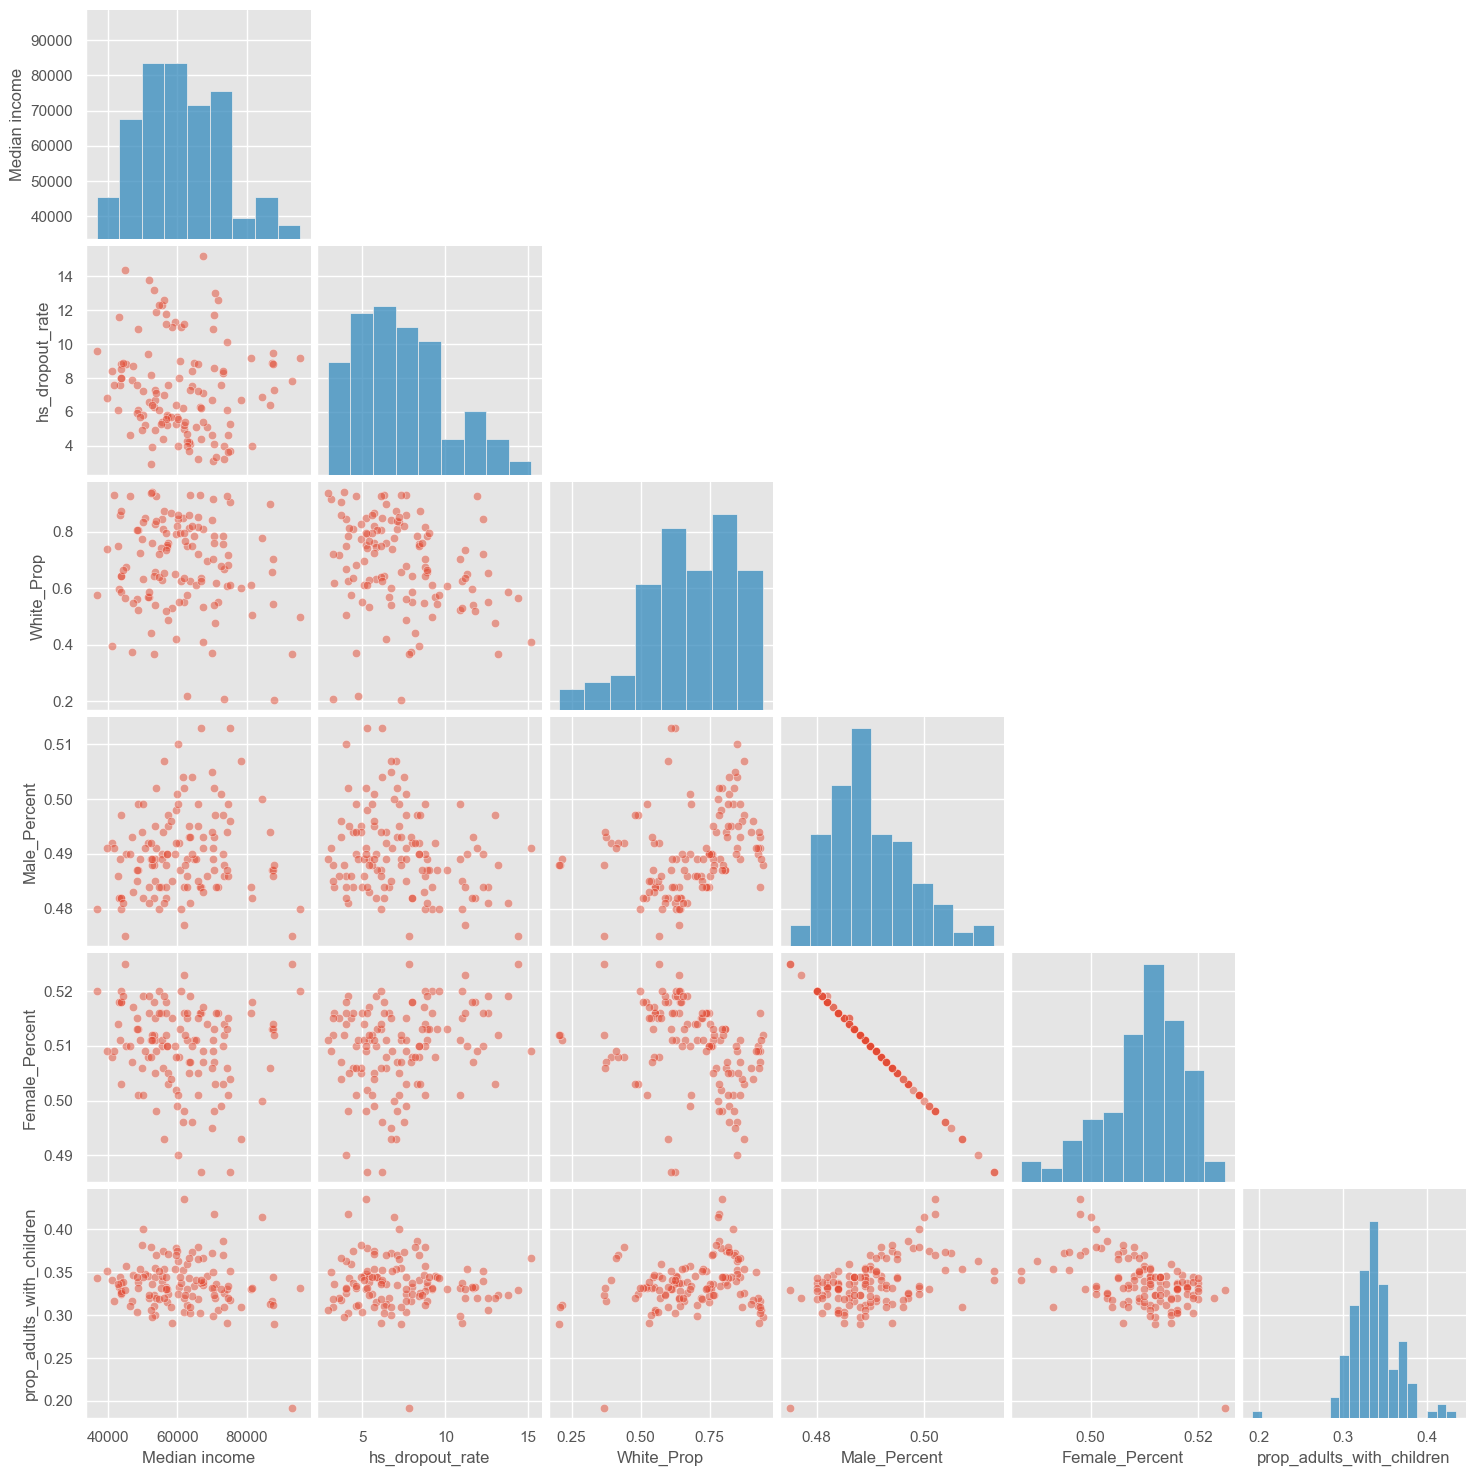

In [9]:
old_df = df2.copy().drop(columns={"prevalence_percent", "avg_sales_per_capita", 
                                  "income_above_50k", "us_overall_party", "year", "treatment", "excise_tax",#"West",
                                  "region_number", "teen_birth_rate", "Population Estimate"})
fig = sns.pairplot(old_df,  plot_kws=dict(marker="o", alpha = 0.5))
for i, j in zip(*np.triu_indices_from(fig.axes, 1)):
    fig.axes[i, j].set_visible(False)
plt.show()

#### Final Dataset

In [10]:

###
df2["West"] = df2["LocationDesc"].replace({"Alaska": "west", 
                                     "Arizona": "west", 
                                     "California": "west", 
                                     "Hawaii": "west", 
                                     "Idaho":"west", 
                                     "Montana": "west", 
                                     "Nevada": "west", 
                                     "New Mexico" : "west", 
                                     "Oregon" : "west", 
                                     "Utah" :"west", 
                                     "Washington" : "west", 
                                     "Wyoming" : "west", 
                                    })
df2["West_Coast"] = df2["West"].str.contains("west")
df2


year state          LocationDesc  prevalence_percent  excise_tax  \
0    2013    WY               Wyoming                17.4         0.0   
1    2013    NY              New York                10.6         1.0   
2    2017    NY              New York                 5.5         0.0   
3    2019    NY              New York                 4.2         0.0   
4    2013    OH                  Ohio                15.1         0.0   
..    ...   ...                   ...                 ...         ...   
119  2017    PA          Pennsylvania                 8.7         0.0   
120  2019    PA          Pennsylvania                 6.6         0.0   
121  2017    VT               Vermont                 9.3         0.0   
122  2019    VT               Vermont                 6.9         0.0   
123  2019    DC  District of Columbia                 5.3         1.0   

     Population Estimate  Median income  avg_sales_per_capita  \
0               582122.0        61570.5                  60.8   
1             19624447.0        51904.5                  16.6   
2             19589572.0        61995.0                  13.3   
3             19453561.0        71855.0                  11.7   
4             11576684.0        48573.0                  54.6   
..                   ...            ...                   ...   
119           12787641.0        62229.0                  40.5   
120           12801989.0        70582.0                  35.7   
121             624344.0        63743.5                  36.3   
122             623989.0        74305.0                  31.5   
123             705749.0        93111.0                   9.1   

    us_overall_party  income_above_50k  ... teen_birth_rate     region  \
0           Democrat                 1  ...            29.6       West   
1           Democrat                 1  ...            17.7  Northeast   
2         Republican                 1  ...            12.5  Northeast   
3         Republican                 1  ...            11.4  Northeast   
4           Democrat                 0  ...            27.2    Midwest   
..               ...               ...  ...             ...        ...   
119       Republican                 1  ...            14.8  Northeast   
120       Republican                 1  ...            13.3  Northeast   
121       Republican                 1  ...            10.1  Northeast   
122       Republican                 1  ...             7.6  Northeast   
123       Republican                 1  ...            16.8      South   

     region_number White_Prop  Male_Percent  Female_Percent  \
0                4      0.850         0.504           0.496   
1                1      0.570         0.484           0.516   
2                1      0.552         0.484           0.516   
3                1      0.552         0.484           0.516   
4                0      0.806         0.487           0.513   
..             ...        ...           ...             ...   
119              1      0.767         0.488           0.512   
120              1      0.760         0.487           0.513   
121              1      0.931         0.493           0.507   
122              1      0.928         0.494           0.506   
123              2      0.367         0.475           0.525   

     prop_adults_with_children  treatment                  West  West_Coast  
0                        0.353          1                  west        True  
1                        0.320          0              New York       False  
2                        0.304          0              New York       False  
3                        0.306          0              New York       False  
4                        0.339          1                  Ohio       False  
..                         ...        ...                   ...         ...  
119                      0.323          0          Pennsylvania       False  
120                      0.323          0          Pennsylvania       False  

In [11]:
df2.head()

#xdf = df2[["Female_Percent", "prevalence_percent", "Median income", "hs_dropout_rate", "White_Prop", "year", "prop_adults_with_children"]]
# xdf

year state LocationDesc  prevalence_percent  excise_tax  \
0  2013    WY      Wyoming                17.4         0.0   
1  2013    NY     New York                10.6         1.0   
2  2017    NY     New York                 5.5         0.0   
3  2019    NY     New York                 4.2         0.0   
4  2013    OH         Ohio                15.1         0.0   

   Population Estimate  Median income  avg_sales_per_capita us_overall_party  \
0             582122.0        61570.5                  60.8         Democrat   
1           19624447.0        51904.5                  16.6         Democrat   
2           19589572.0        61995.0                  13.3       Republican   
3           19453561.0        71855.0                  11.7       Republican   
4           11576684.0        48573.0                  54.6         Democrat   

   income_above_50k  ... teen_birth_rate     region  region_number White_Prop  \
0                 1  ...            29.6       West              4      0.850   
1                 1  ...            17.7  Northeast              1      0.570   
2                 1  ...            12.5  Northeast              1      0.552   
3                 1  ...            11.4  Northeast              1      0.552   
4                 0  ...            27.2    Midwest              0      0.806   

   Male_Percent  Female_Percent  prop_adults_with_children  treatment  \
0         0.504           0.496                      0.353          1   
1         0.484           0.516                      0.320          0   
2         0.484           0.516                      0.304          0   
3         0.484           0.516                      0.306          0   
4         0.487           0.513                      0.339          1   

       West  West_Coast  
0      west        True  
1  New York       False  
2  New York       False  
3  New York       False  
4      Ohio       False  

[5 rows x 22 columns]

In [12]:
set(df2["region"])

{'Midwest', 'Northeast', 'South', 'Southwest', 'West'}

In [13]:
# https://www.britannica.com/place/the-West-region-United-States

df2["West"] = df2["LocationDesc"].replace({"Alaska": "west", 
                                     "Arizona": "west", 
                                     "California": "west", 
                                     "Hawaii": "west", 
                                     "Idaho":"west", 
                                     "Montana": "west", 
                                     "Nevada": "west", 
                                     "New Mexico" : "west", 
                                     "Oregon" : "west", 
                                     "Utah" :"west", 
                                     "Washington" : "west", 
                                     "Wyoming" : "west", 
                                    })
df2["West_Coast"] = df2["West"].str.contains("west")
df2

year state          LocationDesc  prevalence_percent  excise_tax  \
0    2013    WY               Wyoming                17.4         0.0   
1    2013    NY              New York                10.6         1.0   
2    2017    NY              New York                 5.5         0.0   
3    2019    NY              New York                 4.2         0.0   
4    2013    OH                  Ohio                15.1         0.0   
..    ...   ...                   ...                 ...         ...   
119  2017    PA          Pennsylvania                 8.7         0.0   
120  2019    PA          Pennsylvania                 6.6         0.0   
121  2017    VT               Vermont                 9.3         0.0   
122  2019    VT               Vermont                 6.9         0.0   
123  2019    DC  District of Columbia                 5.3         1.0   

     Population Estimate  Median income  avg_sales_per_capita  \
0               582122.0        61570.5                  60.8   
1             19624447.0        51904.5                  16.6   
2             19589572.0        61995.0                  13.3   
3             19453561.0        71855.0                  11.7   
4             11576684.0        48573.0                  54.6   
..                   ...            ...                   ...   
119           12787641.0        62229.0                  40.5   
120           12801989.0        70582.0                  35.7   
121             624344.0        63743.5                  36.3   
122             623989.0        74305.0                  31.5   
123             705749.0        93111.0                   9.1   

    us_overall_party  income_above_50k  ... teen_birth_rate     region  \
0           Democrat                 1  ...            29.6       West   
1           Democrat                 1  ...            17.7  Northeast   
2         Republican                 1  ...            12.5  Northeast   
3         Republican                 1  ...            11.4  Northeast   
4           Democrat                 0  ...            27.2    Midwest   
..               ...               ...  ...             ...        ...   
119       Republican                 1  ...            14.8  Northeast   
120       Republican                 1  ...            13.3  Northeast   
121       Republican                 1  ...            10.1  Northeast   
122       Republican                 1  ...             7.6  Northeast   
123       Republican                 1  ...            16.8      South   

     region_number White_Prop  Male_Percent  Female_Percent  \
0                4      0.850         0.504           0.496   
1                1      0.570         0.484           0.516   
2                1      0.552         0.484           0.516   
3                1      0.552         0.484           0.516   
4                0      0.806         0.487           0.513   
..             ...        ...           ...             ...   
119              1      0.767         0.488           0.512   
120              1      0.760         0.487           0.513   
121              1      0.931         0.493           0.507   
122              1      0.928         0.494           0.506   
123              2      0.367         0.475           0.525   

     prop_adults_with_children  treatment                  West  West_Coast  
0                        0.353          1                  west        True  
1                        0.320          0              New York       False  
2                        0.304          0              New York       False  
3                        0.306          0              New York       False  
4                        0.339          1                  Ohio       False  
..                         ...        ...                   ...         ...  
119                      0.323          0          Pennsylvania       False  
120                      0.323          0          Pennsylvania       False  

# Exploratory Data Analysis (EDA)

Here we visualize at least two quantitative variables and two categorical variables. The visualizations are relevant to out research questions

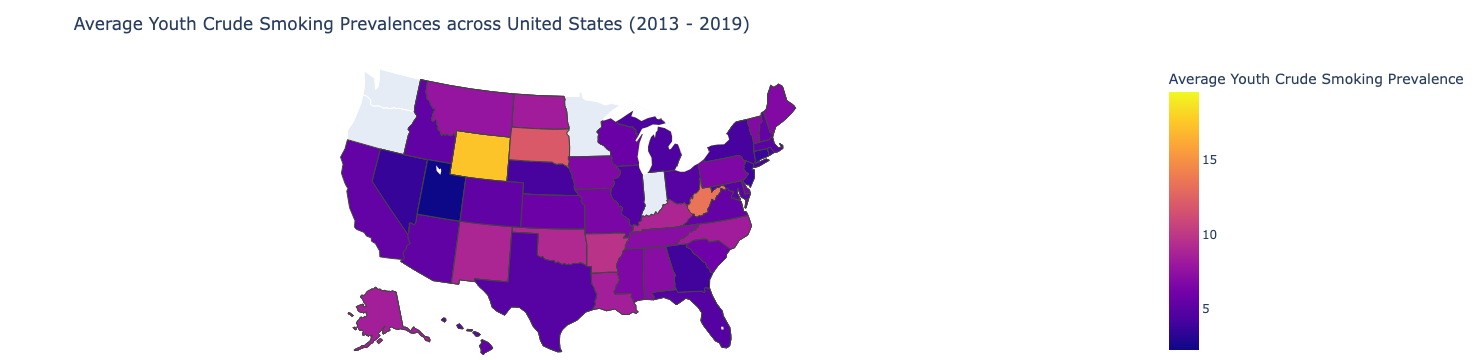

In [14]:
# Youth Smoking Geographically 
fig =  px.choropleth(df2,  # Input Pandas DataFrame
                    locations="state",  # DataFrame column with locations
                    hover_name="LocationDesc", # DataFrame column hover info
                    color ="prevalence_percent",  # DataFrame column with color values
                    labels={'prevalence_percent':'Average Youth Crude Smoking Prevalence'},
                    locationmode = 'USA-states') # Set to plot as US States

fig.update_layout(
    title_text = "Average Youth Crude Smoking Prevalences across United States (2013 - 2019)", 
    geo_scope='usa')
fig.update_layout(margin={"r":0,"l":0,"b":0})
fig.show()

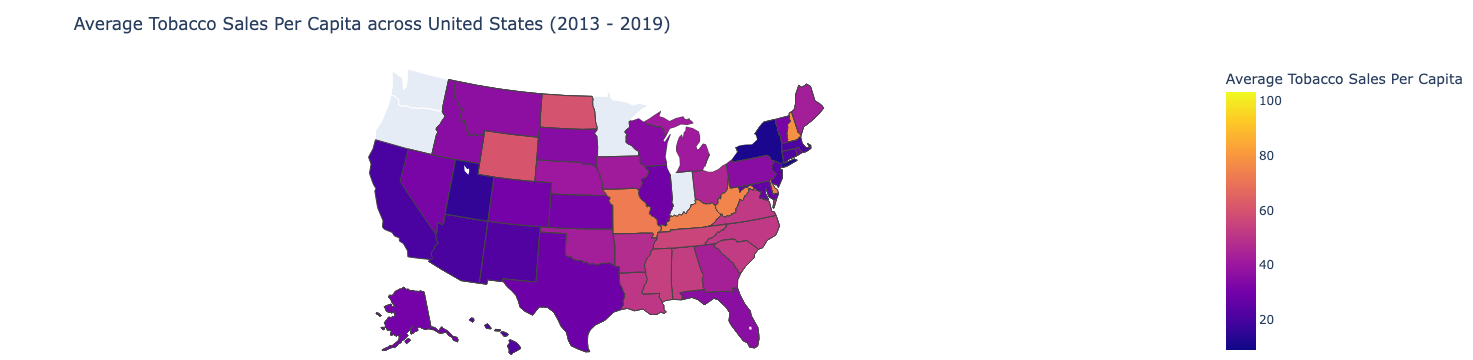

In [15]:
# Tobacco Sales Geographically
fig =  px.choropleth(df2,  # Input Pandas DataFrame
                    locations="state",  # DataFrame column with locations
                    hover_name="LocationDesc", # DataFrame column hover info
                    color ="avg_sales_per_capita",  # DataFrame column with color values
                    labels={'avg_sales_per_capita':'Average Tobacco Sales Per Capita'},
                    locationmode = 'USA-states') # Set to plot as US States

fig.update_layout(
    title_text = "Average Tobacco Sales Per Capita across United States (2013 - 2019)", 
    geo_scope='usa')
fig.update_layout(margin={"r":0,"l":0,"b":0})
fig.show()

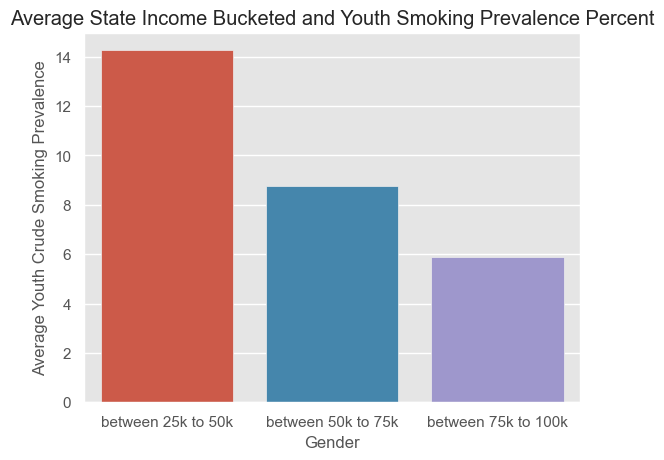

In [16]:
# Income buckets
income_df = df2.groupby("income_bucket").mean().reset_index()

sns.barplot(data = income_df, x = "income_bucket", y = "prevalence_percent");
plt.title("Average State Income Bucketed and Youth Smoking Prevalence Percent")
plt.xlabel('Gender');
plt.ylabel('Average Youth Crude Smoking Prevalence');
plt.show()

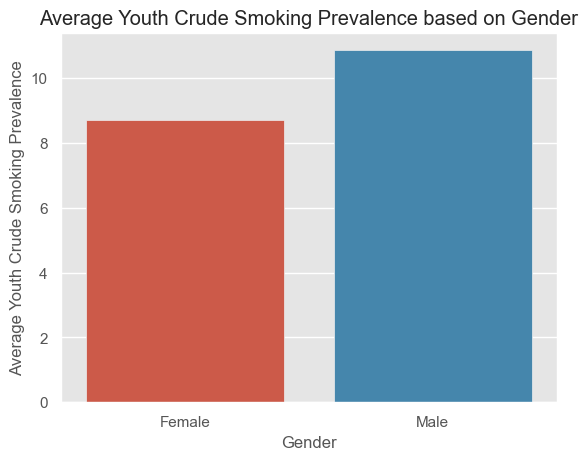

In [17]:
## Youth Prevalence By Gender
youth_prevalence = crude_prevalence[["YearStart", "LocationAbbr", "LocationDesc", 
                                     "DataValue",
                                    "Stratification1"]].rename(columns={"YearStart": "year",
                                                                                        "LocationAbbr": "state",
                                                                                       "DataValue": "prevalence_percent"})
youth_gender = youth_prevalence.copy()
youth = youth_prevalence[youth_prevalence["Stratification1"] == "Overall"]
youth

yg_prev_avg = youth_gender.groupby('Stratification1').sum().reset_index()[['Stratification1', 'prevalence_percent']].iloc[[3,5]]
yg_prev_avg['prevalence_percent'] = yg_prev_avg['prevalence_percent'] / 167
yg_prev_avg = yg_prev_avg.rename(columns = {'Stratification1' : 'Gender', 'prevalence_percent' : 'Avg_prevalence'})
yg_prev_avg

sns.barplot(data = yg_prev_avg, x = 'Gender', y = 'Avg_prevalence');
plt.title("Average Youth Crude Smoking Prevalence based on Gender");
plt.xlabel('Gender');
plt.ylabel('Average Youth Crude Smoking Prevalence');
plt.show()

# Question #1: Causal Inference

The following code below relates to our first research question involving Causal Inference. 

In [18]:
input_df = df2[["Median income", "excise_tax", "hs_dropout_rate", "teen_birth_rate", 
                "Population Estimate", "White_Prop", "prop_adults_with_children", "prevalence_percent", "treatment", "avg_sales_per_capita", 
                "year", "state", "region", "West_Coast", "Male_Percent", "Female_Percent"]]
display(input_df)

Median income  excise_tax  hs_dropout_rate  teen_birth_rate  \
0          61570.5         0.0              6.2             29.6   
1          51904.5         1.0              6.6             17.7   
2          61995.0         0.0              5.0             12.5   
3          71855.0         0.0             12.6             11.4   
4          48573.0         0.0              6.1             27.2   
..             ...         ...              ...              ...   
119        62229.0         0.0              5.4             14.8   
120        70582.0         0.0              8.6             13.3   
121        63743.5         0.0              7.3             10.1   
122        74305.0         0.0              6.1              7.6   
123        93111.0         1.0              7.8             16.8   

     Population Estimate  White_Prop  prop_adults_with_children  \
0               582122.0       0.850                      0.353   
1             19624447.0       0.570                      0.320   
2             19589572.0       0.552                      0.304   
3             19453561.0       0.552                      0.306   
4             11576684.0       0.806                      0.339   
..                   ...         ...                        ...   
119           12787641.0       0.767                      0.323   
120           12801989.0       0.760                      0.323   
121             624344.0       0.931                      0.309   
122             623989.0       0.928                      0.291   
123             705749.0       0.367                      0.192   

     prevalence_percent  treatment  avg_sales_per_capita  year state  \
0                  17.4          1                  60.8  2013    WY   
1                  10.6          0                  16.6  2013    NY   
2                   5.5          0                  13.3  2017    NY   
3                   4.2          0                  11.7  2019    NY   
4                  15.1          1                  54.6  2013    OH   
..                  ...        ...                   ...   ...   ...   
119                 8.7          0                  40.5  2017    PA   
120                 6.6          0                  35.7  2019    PA   
121                 9.3          0                  36.3  2017    VT   
122                 6.9          0                  31.5  2019    VT   
123                 5.3          0                   9.1  2019    DC   

        region  West_Coast  Male_Percent  Female_Percent  
0         West        True         0.504           0.496  
1    Northeast       False         0.484           0.516  
2    Northeast       False         0.484           0.516  
3    Northeast       False         0.484           0.516  
4      Midwest       False         0.487           0.513  
..         ...         ...           ...             ...  
119  Northeast       False         0.488           0.512  
120  Northeast       False         0.487           0.513  
121  Northeast       False         0.493           0.507  
122  Northeast       False         0.494           0.506  
123      South       False         0.475           0.525  

[124 rows x 16 columns]

Showing Distribution of the Average Sales per Capita for the dataset

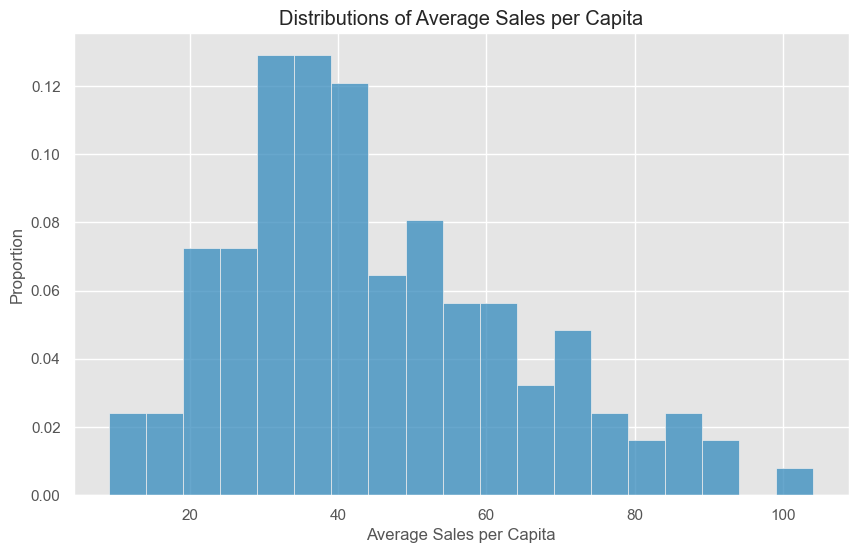

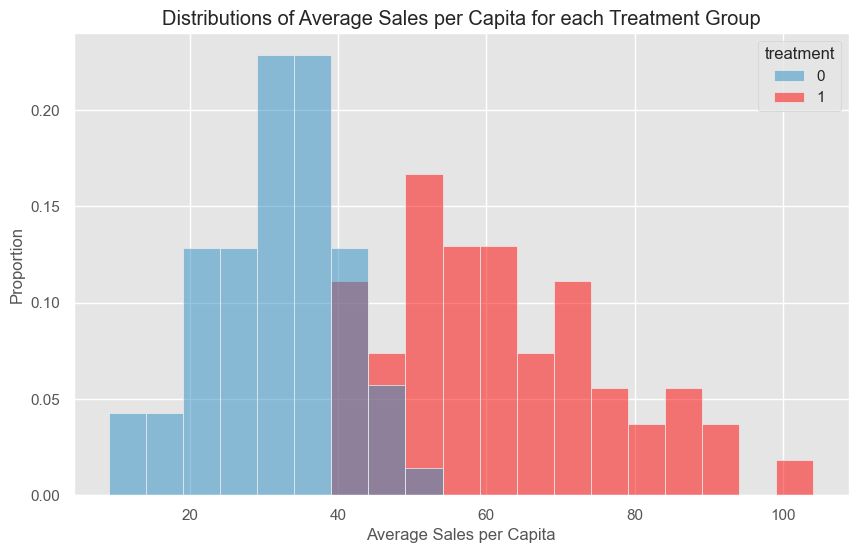

In [19]:
plt.figure(figsize=(10, 6)) 
custom_palette = ["#2B8CC4", "#FF0000"]
sns.histplot(data=input_df, x='avg_sales_per_capita', stat='probability', common_norm=False, binwidth=5, palette=custom_palette);
plt.title("Distributions of Average Sales per Capita");
plt.xlabel('Average Sales per Capita');
plt.ylabel('Proportion');
plt.show()

plt.figure(figsize=(10, 6)) 
custom_palette = ["#2B8CC4", "#FF0000"]
sns.histplot(data=input_df, x='avg_sales_per_capita', stat='probability', hue='treatment', common_norm=False, binwidth=5, palette=custom_palette);
plt.title("Distributions of Average Sales per Capita for each Treatment Group");
plt.xlabel('Average Sales per Capita');
plt.ylabel('Proportion');
plt.show()

Showing Distribution of Youth Prevalence Smoking Rates for each Treatment Group for each treatment group

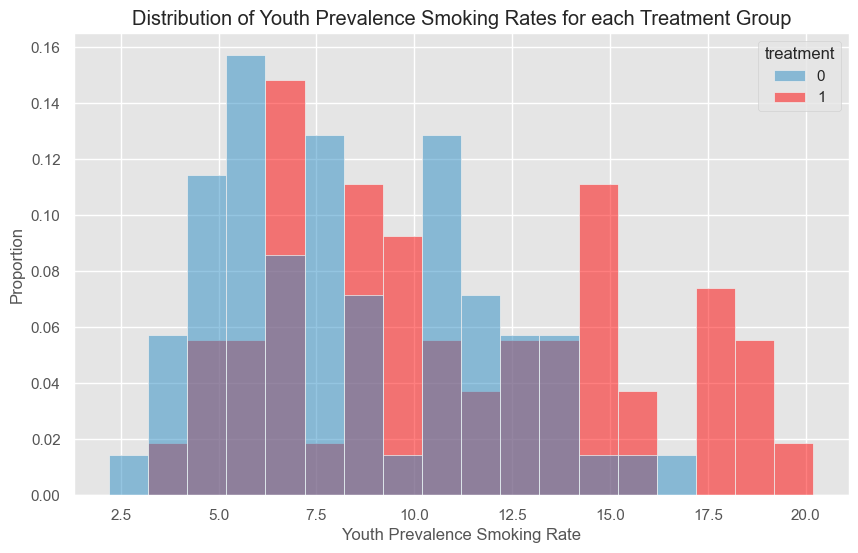

In [20]:
plt.figure(figsize=(10, 6)) 
custom_palette = ["#2B8CC4", "#FF0000"]
sns.histplot(data=input_df, x='prevalence_percent', hue='treatment', stat='probability', common_norm=False, binwidth=1, palette=custom_palette);
plt.title("Distribution of Youth Prevalence Smoking Rates for each Treatment Group");
plt.xlabel('Youth Prevalence Smoking Rate');
plt.ylabel('Proportion');

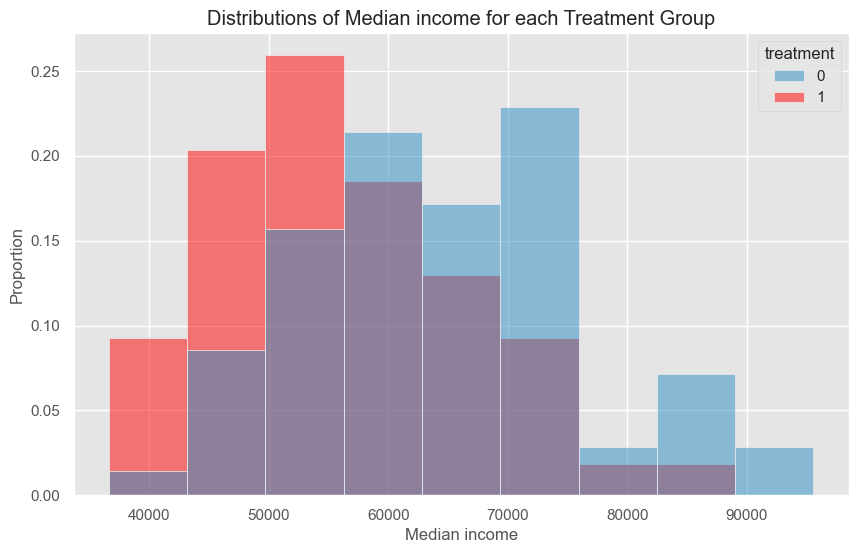

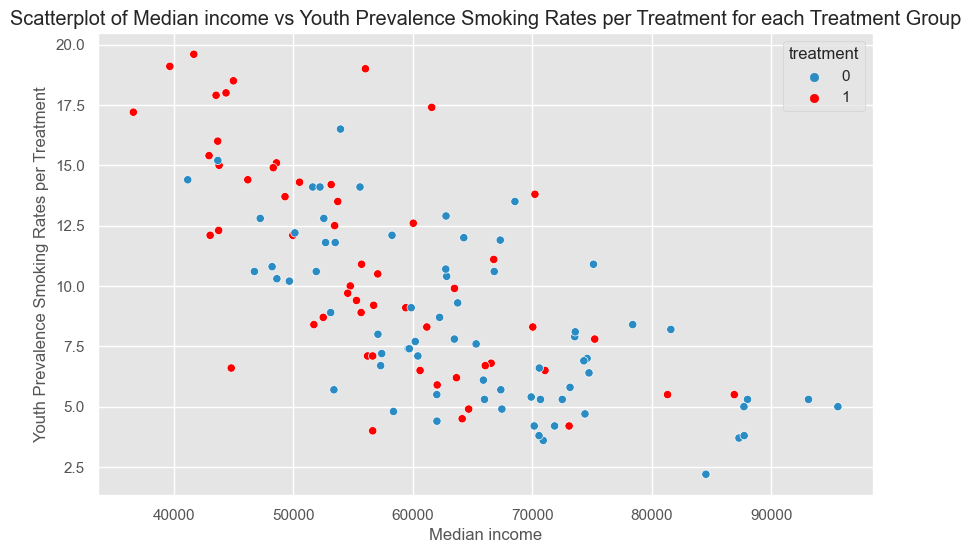

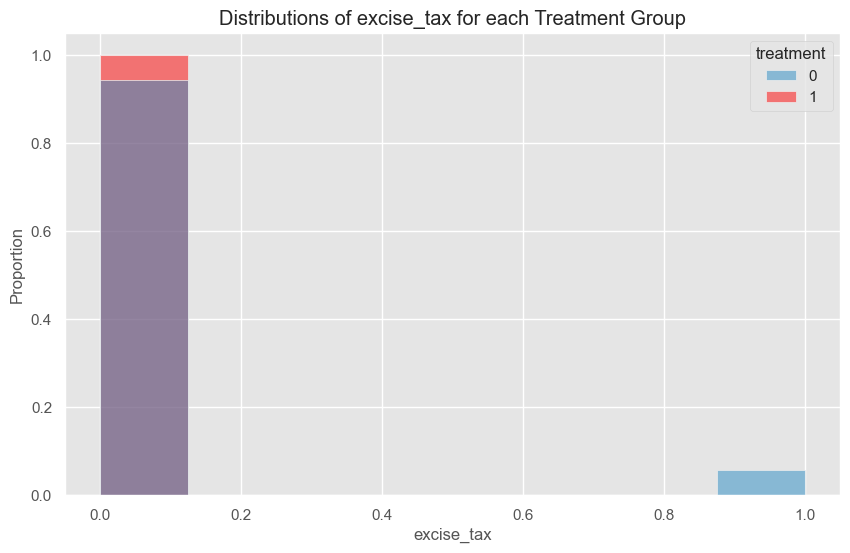

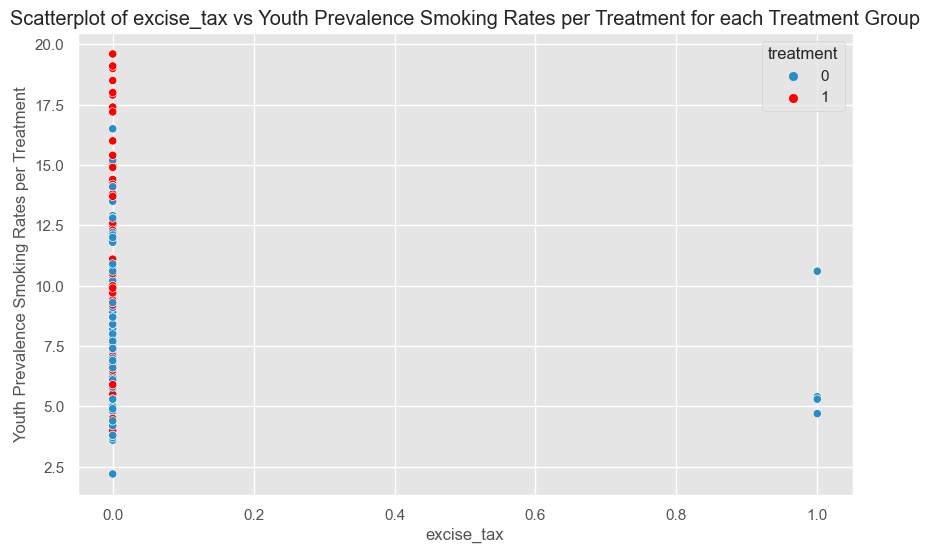

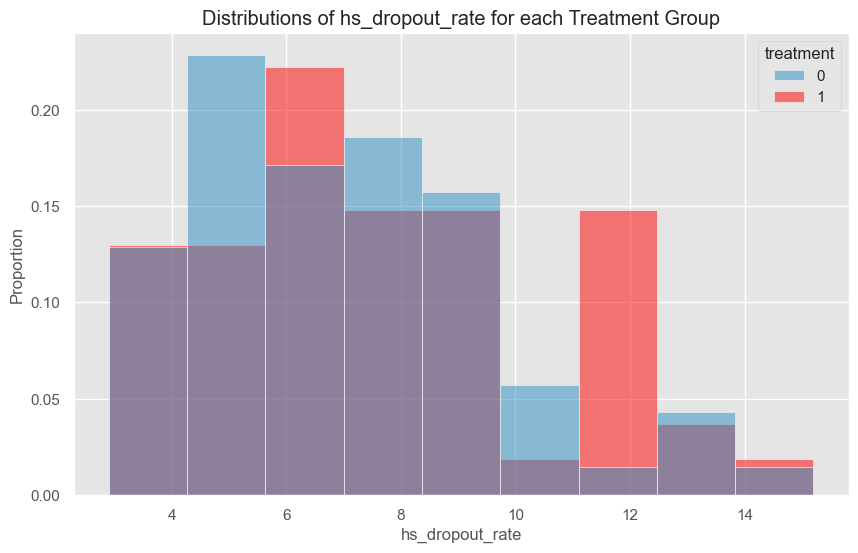

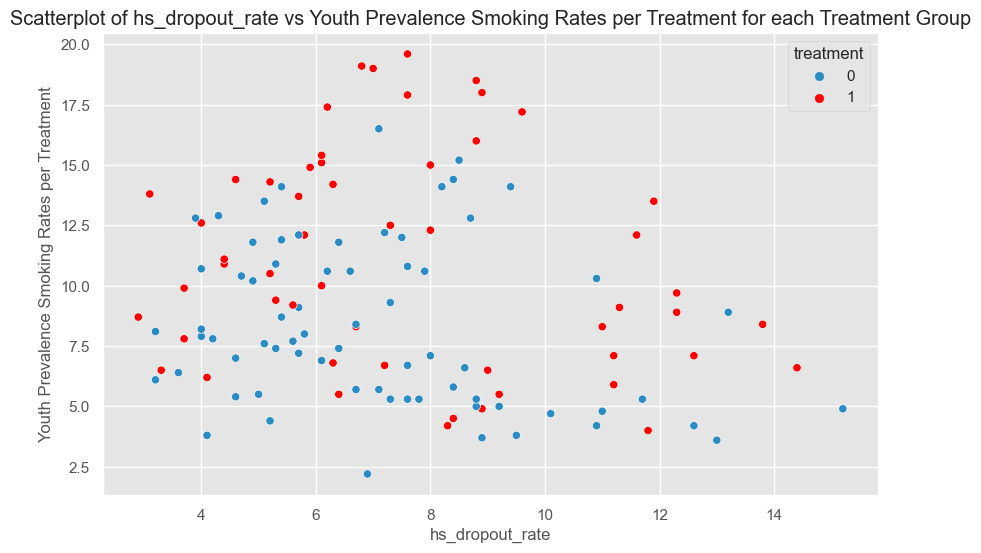

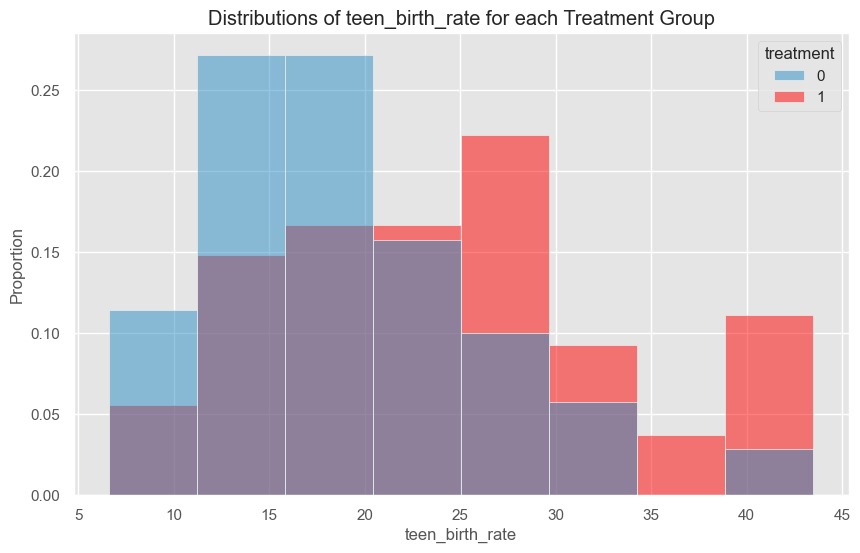

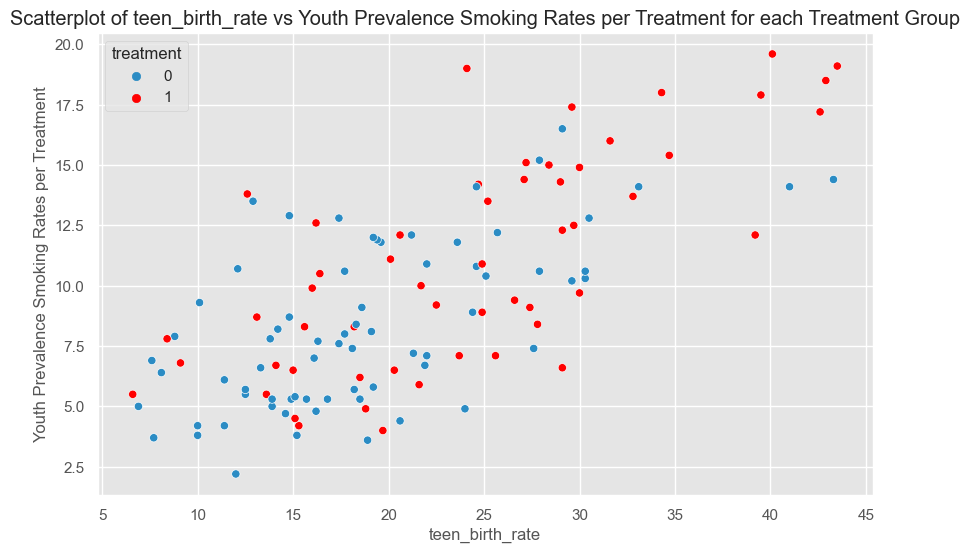

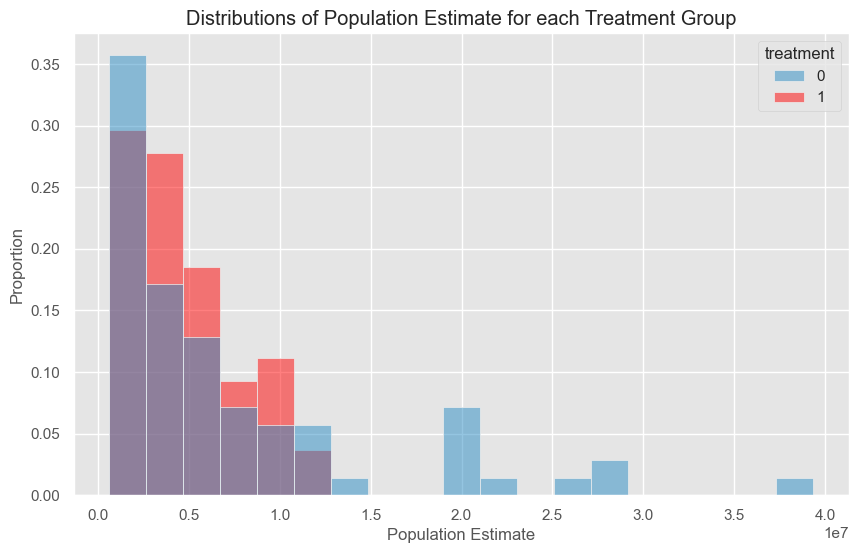

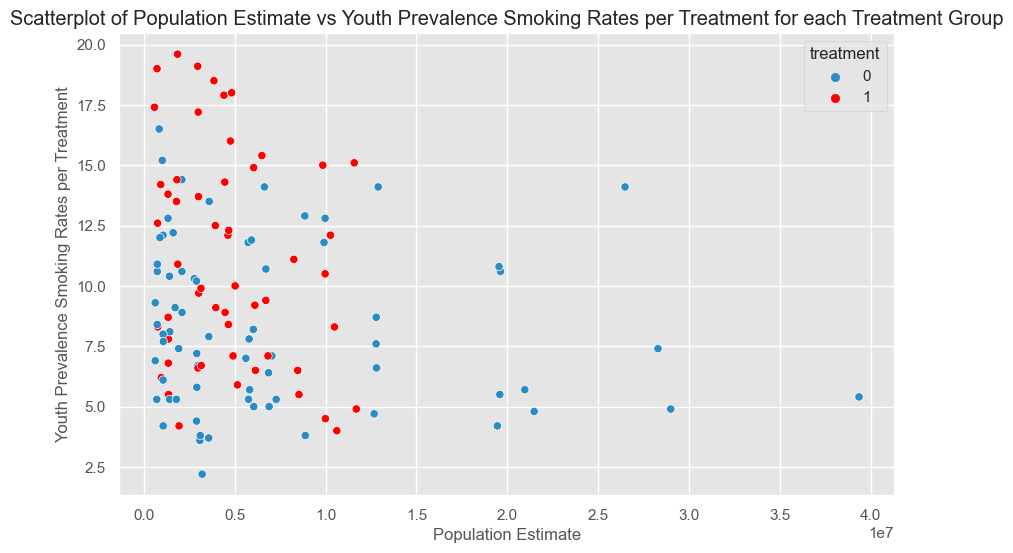

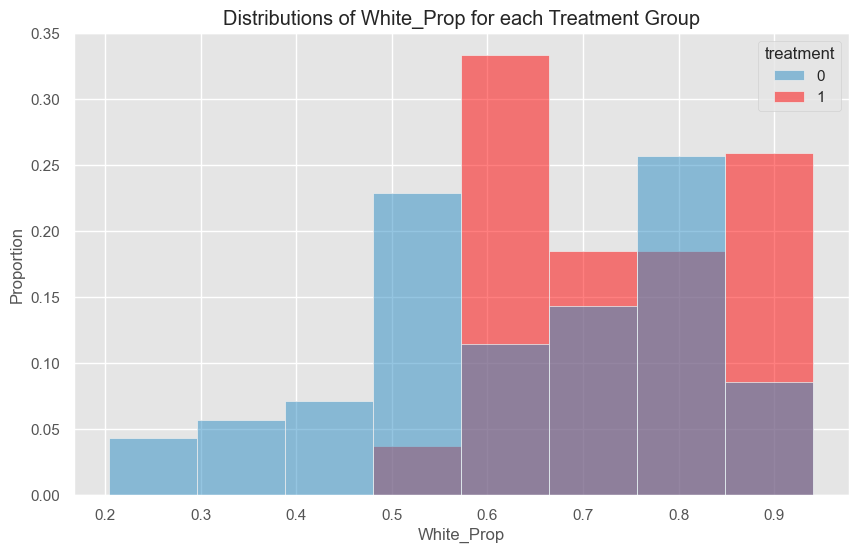

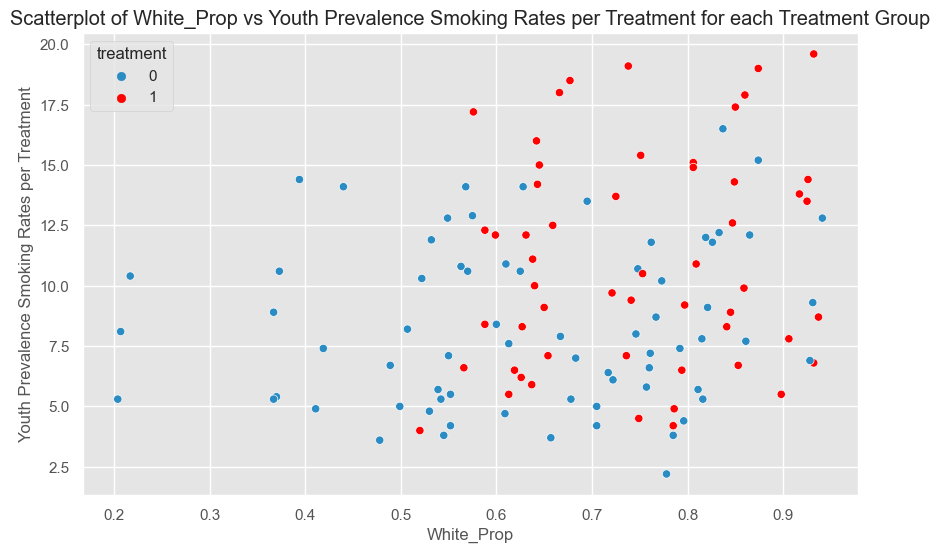

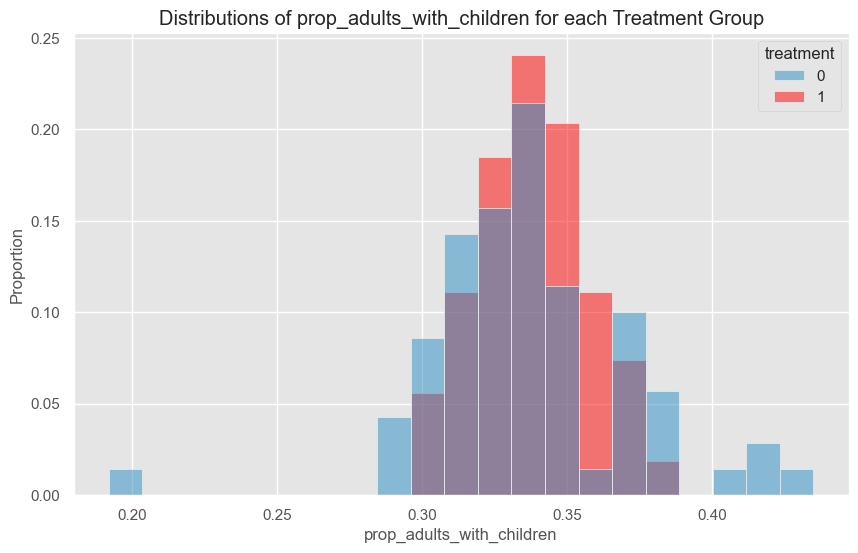

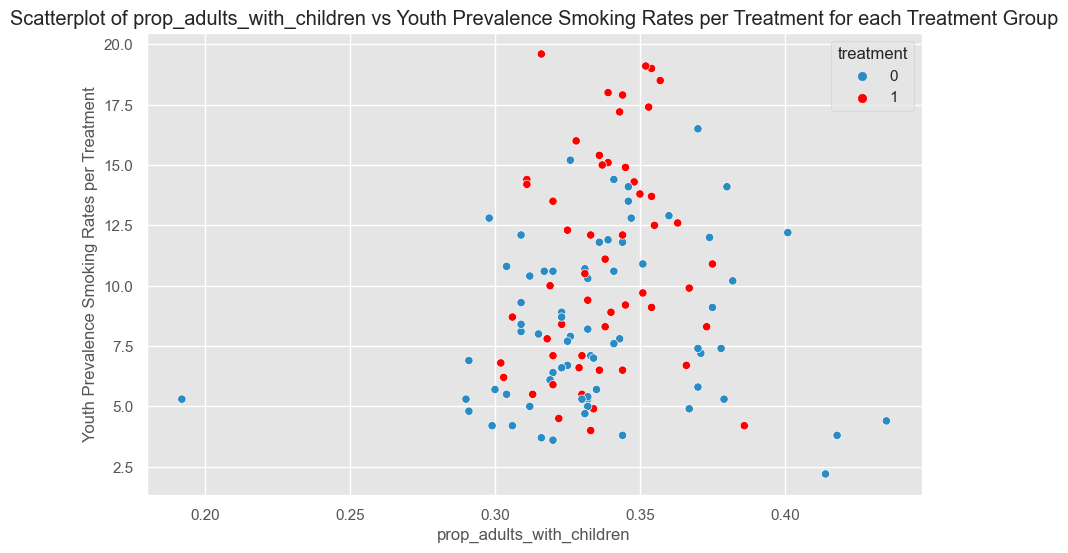

In [21]:
cofounders = ["Median income", "excise_tax", "hs_dropout_rate", "teen_birth_rate", 
              "Population Estimate", "White_Prop",  "prop_adults_with_children"]

custom_palette = ["#2B8CC4", "#FF0000"]

for cofounder in cofounders:
    plt.figure(figsize=(10, 6)) 
    sns.histplot(data=input_df, x=cofounder, hue='treatment', stat='probability', common_norm=False, palette=custom_palette);
    plt.title("Distributions of " + cofounder + " for each Treatment Group");
    plt.xlabel(cofounder)
    plt.ylabel('Proportion')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=input_df, x=cofounder, y='prevalence_percent', hue='treatment', palette=custom_palette);
    plt.title("Scatterplot of " + cofounder + " vs Youth Prevalence Smoking Rates per Treatment for each Treatment Group");
    plt.xlabel(cofounder)
    plt.ylabel('Youth Prevalence Smoking Rates per Treatment')
    plt.show()

# **Unconfoundedness Techniques**

**REMINDER:** the unconfoundedness assumption means we observe all the relevant confounding variables (like years of education). I.e. there are no **unobserved** confounders.

## **Technique 1: Inverse Propensity Weighting**
The definition of the propensity score: it is the probability that a unit was treated, conditioned on a particular set of confounders $x$:

$$
e(x) = P(Z=1 | X=x)
$$

This is also sometimes called a "selection model" because it uses the covariates to model how observations are selected into treatment or control.  The simplest and most common way to compute propensity scores is using logistic regression.

### Inverse propensity weighting

We'll focus on inverse propensity weighting (IPW). Let $n = n_0 + n_1$ be the total number of observations.The IPW estimator of the ATE is defined as:

$$
\hat{\tau}_{IPW} =
    \frac{1}{n}
    \underbrace{%
         \sum_{i: Z_i = 1} \frac{Y_i}{e(X_i)}
    }_{\text{reweighted treated rows}}
    -
    \frac{1}{n}
    \underbrace{%
        \sum_{i: Z_i = 0} \frac{Y_i}{1-e(X_i)}
    }_{\text{reweighted control rows}}
$$

Note that the weights are different for the two groups. Intuitively, the weights decrease the importance of points that have a high probability of being in the group that they're in. The idea is that we give more weight to control units who look like the treatment group and less weight to control units who don't so that we can make the two groups more comparable. 

Min Propensity Score: 0.13200426080472377
Max Propensity Score: 0.4633816937978783

 # Propensity Scores for Z=0: 70
Min Propensity Score for Z=0: 0.13200426080472377
Max Propensity Score for Z=0: 0.4633816937978783

 # Propensity Scores for Z=1: 54
Min Propensity Score for Z=1: 0.3402110716142425
Max Propensity Score for Z=1: 0.45934324887384625


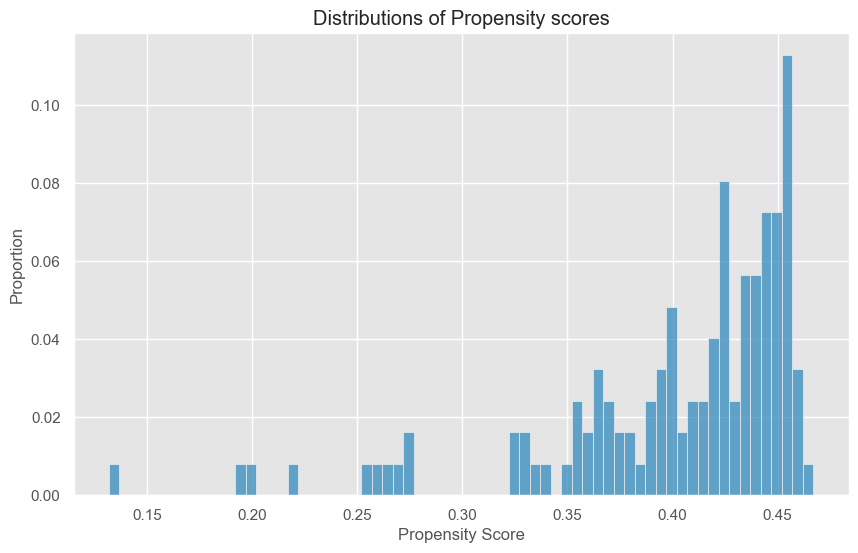

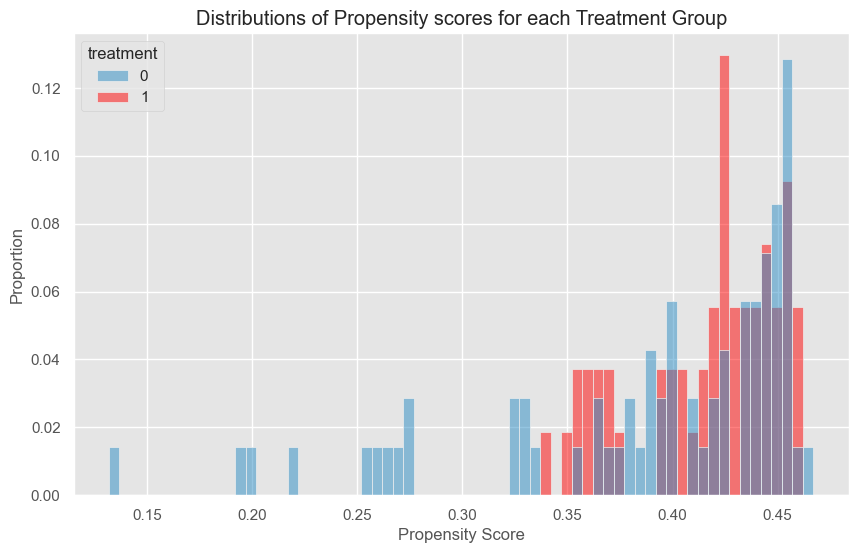

In [22]:
random.seed(1234)
np.random.seed(1234)

# fit logistic regression to estimate propensity scores
X = input_df[["Median income", "excise_tax", "hs_dropout_rate", "teen_birth_rate", 
     "Population Estimate", "White_Prop", "prop_adults_with_children"]]
y = input_df['treatment']
lr = LR(penalty='none', max_iter=200, random_state=1234)
lr.fit(X, y)
ps = lr.predict_proba(X)[:, 1]

input_with_ps_df = input_df.copy()
input_with_ps_df['pscore'] = ps

# print min and max values of the Propensity Scores
print("Min Propensity Score:", min(input_with_ps_df["pscore"]))
print("Max Propensity Score:", max(input_with_ps_df["pscore"]))
print()
print(" # Propensity Scores for Z=0:", len(input_with_ps_df[input_with_ps_df["treatment"]==0]))
print("Min Propensity Score for Z=0:", min(input_with_ps_df[input_with_ps_df["treatment"]==0]["pscore"]))
print("Max Propensity Score for Z=0:", max(input_with_ps_df[input_with_ps_df["treatment"]==0]["pscore"]))
print()
print(" # Propensity Scores for Z=1:", len(input_with_ps_df[input_with_ps_df["treatment"]==1]))
print("Min Propensity Score for Z=1:", min(input_with_ps_df[input_with_ps_df["treatment"]==1]["pscore"]))
print("Max Propensity Score for Z=1:", max(input_with_ps_df[input_with_ps_df["treatment"]==1]["pscore"]))

# Display Distribution of Propensity scores
plt.figure(figsize=(10, 6))
sns.histplot(data=input_with_ps_df, x='pscore', common_norm=False, stat='probability', binwidth=0.005);
plt.title("Distributions of Propensity scores");
plt.xlabel('Propensity Score')
plt.ylabel('Proportion')
plt.show()

# Display Distribution of Propensity scores for each Treatment Group
custom_palette = ["#2B8CC4", "#FF0000"]
plt.figure(figsize=(10, 6))
sns.histplot(data=input_with_ps_df, x='pscore', common_norm=False, hue='treatment', stat='probability', binwidth=0.005, palette=custom_palette);
plt.title("Distributions of Propensity scores for each Treatment Group");
plt.xlabel('Propensity Score')
plt.ylabel('Proportion')
plt.show()

Calculating the IPW and Naive Estimate for the average treatment effect

In [23]:
random.seed(1234)
np.random.seed(1234)

X = input_df[["Median income", "excise_tax", "hs_dropout_rate", "teen_birth_rate", 
     "Population Estimate", "White_Prop", "prop_adults_with_children"]].copy()
Y = input_df['prevalence_percent'].copy()
Z = input_df['treatment'].copy()

lr = LR(penalty='none', max_iter=200, random_state=1234)
lr.fit(X, Z)

def naive_esimator(Y, Z):
    n = len(Z)
    n1 = np.sum(Z)
    n0 = n - n1
    tau = np.sum((1/n1)*(Z*Y) - (1/n0)*((1-Z)*Y))
    return tau

def estimate_treatment_effect(lr, X, Y, Z):
    ex = lr.predict_proba(X)[:, 1]
    return np.mean(Z * Y / ex) - np.mean((1 - Z) * Y / (1 - ex))

# estimating of the average treatment effect

"""
Unlike the estimator derived in the previous problem, this naive estimator does not take into account the existence of confounders between X and Y
If X and Y are not confounded at all, however, these two estimators should produce the same estimates.
"""

# inverse propensity weighted estimator
print("Estimate from Inverse Propensity Weighted Estimator:", estimate_treatment_effect(lr, X, Y, Z))

# naive esimator
print("Estimate from Naive Estimator:",  naive_esimator(Y, Z))

Estimate from Inverse Propensity Weighted Estimator: 3.5831208069815927
Estimate from Naive Estimator: 2.698994708994708


### Trimming our propensities

If some observations are rare in the treatment group (i.e. $e(X) \approx 0$) then the inverse propensity score, $1/e(X)$ can be enormous. Our estimator gets swamped by variance. Recent work in IPW suggests that a good rule of thumb is to only include points with propensity scores between 0.1 and 0.9 which accepts some bias to reduce the variance.

In the cell below, we remove any data points with propensity scores that are too low or too high. 

In [24]:
cleaned_input_with_ps_df = input_with_ps_df.loc[(input_with_ps_df['pscore'] >= 0.10) & (input_with_ps_df['pscore'] <= 0.90)]
n = len(cleaned_input_with_ps_df)
e = cleaned_input_with_ps_df['pscore']
y = cleaned_input_with_ps_df['prevalence_percent']
treat = cleaned_input_with_ps_df['treatment'] == 1
trimmed_ipw_estimate = (np.sum(y[treat] / e[treat])/n) - (np.sum(y[~treat] / (1-e[~treat]))/n) 

# AFTER trimming, would it be true to say that 
# confounders have deflated the apparent causal effect of the treatment on the outcome, as this naive estimate is smaller than the corrected estimate?

print("Estimate from Inverse Propensity Weighted Estimator after trimming:", trimmed_ipw_estimate)

Estimate from Inverse Propensity Weighted Estimator after trimming: 3.5831208069815927


### Bootstrap IPW and Naive ATE Estimate

Performing Bootstrap for the IPW and Naive ATE Estimate

In [25]:
random.seed(1234)
np.random.seed(1234)

def draw_ipw_estimate(input_data, random_state=None):
    """
    np.random.seed(1234)
    rand_ints = [random.randint(0, len(input_data)-1) for i in range(len(input_data))]
    sample = pd.DataFrame([input_data.iloc[i] for i in rand_ints], index=range(len(input_data)))
    """
    sample = input_data.sample(n=len(input_data), replace=True)
    X = sample[["Median income", "excise_tax", "hs_dropout_rate", "teen_birth_rate",  
                "Population Estimate", "White_Prop", "prop_adults_with_children"]].copy()
    Y = sample['prevalence_percent'].copy()
    Z = sample['treatment'].copy()
    lr = LR(penalty='none', max_iter=200, random_state=1234)
    lr.fit(X, Z)
    return estimate_treatment_effect(lr, X, Y, Z), lr.coef_[0]

def get_bootstrapped_ipw_estimate(input_data, n=1000, random_state=None):
    estimates = []
    coefficient_lst = []
    random.seed(1234)
    np.random.seed(1234)
    for i in np.arange(n):
        estimate, coefficients = draw_ipw_estimate(input_data, random_state)
        estimates.append(estimate)
        coefficient_lst.append(coefficients)
    return estimates, coefficient_lst
    
def draw_naive_estimate(input_data, random_state=None):
    """
    np.random.seed(1234)
    rand_ints = [random.randint(0, len(input_data)-1) for i in range(len(input_data))]
    sample = pd.DataFrame([input_data.iloc[i] for i in rand_ints], index=range(len(input_data)))
    """
    sample = input_data.sample(n=len(input_data), replace=True)
    rand_ints = [random.randint(0, len(input_data)-1) for i in range(len(input_data))]
    sample = pd.DataFrame([input_data.iloc[i] for i in rand_ints], index=range(len(input_data)))
    X = sample[["Median income", "excise_tax", "hs_dropout_rate", "teen_birth_rate",  
                "Population Estimate", "White_Prop", "prop_adults_with_children"]].copy()
    Y = sample['prevalence_percent'].copy()
    Z = sample['treatment'].copy()
    return naive_esimator(Y, Z)
    
def get_bootstrapped_naive_estimate(input_data, n=1000, random_state=None):
    estimates = []
    random.seed(1234)
    np.random.seed(1234)
    for i in np.arange(n):
        estimates.append(draw_naive_estimate(input_data, random_state=None))
    return estimates 
                    
def run_bootstrap_for_naive_estimate(input_data, n=1000, random_state=None):
    ates = get_bootstrapped_naive_estimate(input_df.copy(), n, random_state) 
    confidence_interval = [np.percentile(ates, 2.5), np.percentile(ates, 97.5)]
    print('The 95% confidence interval for n=' + str(n) + ' ranges from ' 
          + str(np.round(confidence_interval[0], 2)) + ' to ' + str(np.round(confidence_interval[1], 2)))
    sns.histplot(ates, color="orange", label="Naive Estimator", bins=50)
    plt.hlines(1, confidence_interval[0], confidence_interval[1], linewidth=5)
    plt.title("Bootstrapped Estimates of the Naive $\\tau$");
    plt.xlabel('Naive $\\tau$ Estimate')
    plt.ylabel('Count')
    plt.show()      
    
def run_bootstrap_for_ipw_and_naive_estimate(input_data, n=1000, random_state=None):
    
    columns = ["Median income", "excise_tax", "hs_dropout_rate", "teen_birth_rate",  
                "Population Estimate", "White_Prop", "prop_adults_with_children"]
    
    ipw_ates, ipw_coeff_lst, = get_bootstrapped_ipw_estimate(input_df.copy(), n, random_state)
    
    # Calculate the mean and standard error of the coefficients
    coef_means = np.mean(ipw_coeff_lst, axis=0)
    coef_std_errs = np.std(ipw_coeff_lst, axis=0)
    # Create a DataFrame to store the coefficient means and standard errors
    coefficient_table = pd.DataFrame({'Variable': columns, 'Mean': coef_means, 'Standard Deviation': coef_std_errs,
                                      '2.5 percentile': np.percentile(ipw_coeff_lst, 2.5, axis=0), '97.5 percentile': np.percentile(ipw_coeff_lst, 97.5, axis=0)})
    display(coefficient_table)
    
    
    naive_ates = get_bootstrapped_naive_estimate(input_df.copy(), n, random_state) 
    
    ipw_confidence_interval = [np.percentile(ipw_ates, 2.5), np.percentile(ipw_ates, 97.5)]
    naive_confidence_interval = [np.percentile(naive_ates, 2.5), np.percentile(naive_ates, 97.5)]
    
    print('IPW Esimate: The 95% confidence interval for n=' + str(n) + ' ranges from ' 
          + str(np.round(ipw_confidence_interval[0], 2)) + ' to ' + str(np.round(ipw_confidence_interval[1], 2)))
    sns.histplot(ipw_ates, label="IPW Estimator", bins=50)
    plt.hlines(1, ipw_confidence_interval[0], ipw_confidence_interval[1], linewidth=5)
    plt.title("Bootstrapped Estimates of the $\\tau_{IPW}$");
    plt.xlabel('$\\tau_{IPW}$ Estimate')
    plt.ylabel('Count')
    plt.show()   
    
    print('Naive Esimate: The 95% confidence interval for n=' + str(n) + ' ranges from ' 
          + str(np.round(naive_confidence_interval[0], 2)) + ' to ' + str(np.round(naive_confidence_interval[1], 2)))
    sns.histplot(naive_ates, color="orange", label="Naive Estimator", bins=50)
    plt.hlines(1, naive_confidence_interval[0], naive_confidence_interval[1], linewidth=5)
    plt.title("Bootstrapped Estimates of the Naive $\\tau$");
    plt.xlabel('Naive $\\tau$ Estimate')
    plt.ylabel('Count')
    plt.show()  
    
    print('IPW Esimate: The 95% confidence interval for n=' + str(n) + ' ranges from ' 
          + str(np.round(ipw_confidence_interval[0], 2)) + ' to ' + str(np.round(ipw_confidence_interval[1], 2)))
    print('Naive Esimate: The 95% confidence interval for n=' + str(n) + ' ranges from ' 
          + str(np.round(naive_confidence_interval[0], 2)) + ' to ' + str(np.round(naive_confidence_interval[1], 2)))
    sns.histplot(ipw_ates, label="IPW Estimator", bins=50)
    sns.histplot(naive_ates, color="orange", label="Naive Estimator", bins=50)
    plt.title("Bootstrapped Estimates of the $\\tau_{IPW}$ vs Naive $\\tau$");
    plt.xlabel('ATE Estimate')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

Variable          Mean  Standard Deviation  \
0              Median income -2.626515e-06        4.229489e-06   
1                 excise_tax -2.746249e-06        3.842629e-05   
2            hs_dropout_rate  1.061790e-04        1.302787e-03   
3            teen_birth_rate  5.456241e-04        6.703438e-03   
4        Population Estimate -4.236573e-08        2.735359e-08   
5                 White_Prop  1.164290e-05        1.417645e-04   
6  prop_adults_with_children  3.228450e-06        4.045159e-05   

   2.5 percentile  97.5 percentile  
0   -1.013945e-05     5.076425e-06  
1   -4.520536e-11    -2.689101e-15  
2   -3.284485e-10     1.694928e-09  
3    4.825945e-13     7.084808e-09  
4   -9.614862e-08     1.421936e-08  
5   -2.565128e-11     1.684527e-10  
6   -2.830104e-11     5.563025e-11

IPW Esimate: The 95% confidence interval for n=1000 ranges from 1.51 to 5.24


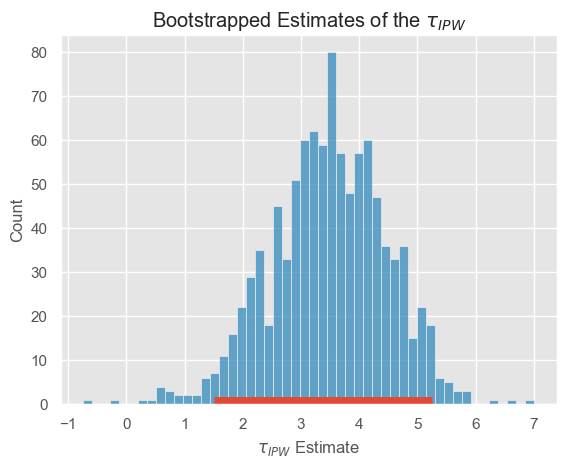

Naive Esimate: The 95% confidence interval for n=1000 ranges from 1.32 to 4.06


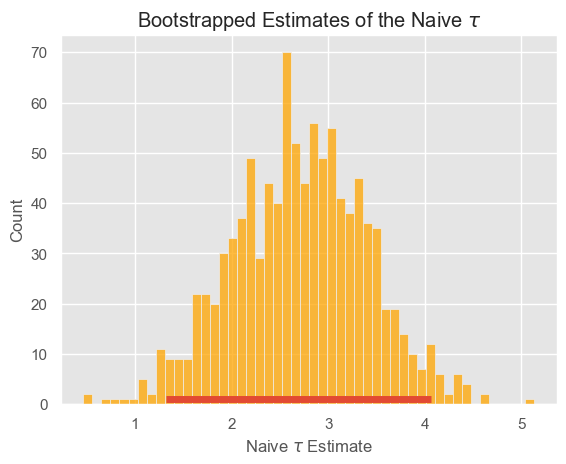

IPW Esimate: The 95% confidence interval for n=1000 ranges from 1.51 to 5.24
Naive Esimate: The 95% confidence interval for n=1000 ranges from 1.32 to 4.06


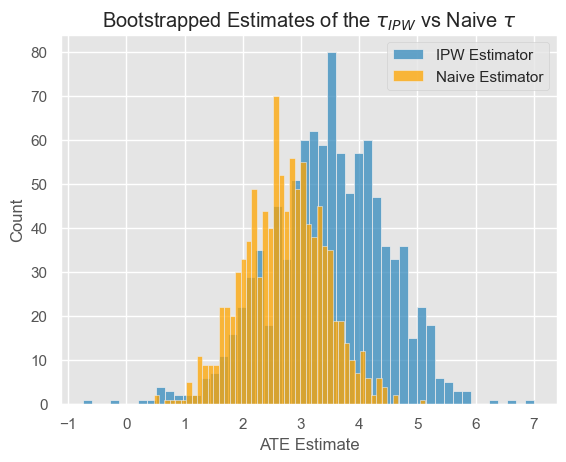

Time taken: 10.911693096160889 seconds
Time taken: 0.0 minutes


In [26]:
random.seed(1234)
np.random.seed(1234)
start_time = time.time()

run_bootstrap_for_ipw_and_naive_estimate(input_with_ps_df, 1000)

end_time = time.time()
print("Time taken:", end_time - start_time, "seconds")
print("Time taken:", (end_time - start_time)//60, "minutes")

# Question #2: Multiple Hypothesis Testing

We are seeing whethere any of the following variables have any effect on youth smoking prevalence & average tobacco sales per capita:


Variables that we can use (based on pairplot for seeing independence & domain knowledge) are:
- (1) Female_Percent
- (2) Median Income
- (3) HS Dropout Rate
- (4) Proportion of White Individuals
- (5) Year
- (6) Proportion of Adults with Children

## A/B Testing For P_values (Like HW #1) 

**Note: This takes a while to run!!**

(an example of Hypothesis Test)

$H_0$ : There is no difference in the average value of `prevalence_percent` (youth crude prevalence smoking rates) between the two groups specified in `excise_tax` (states with tobacco excise tax vs no excise tax)

$H_1$ : The average value of `prevalence_percent` is different for the two groups specified in `excise_tax`.


Assumptions: independence of observations, homogeneity, and certain distributional assumptions (e.g. Normality)



In [27]:
# CLT, assume empirical is normal, compute power

In [28]:
## Based on HW 1
def avg_difference_in_means(binary_col, numerical_col, df2):
    def one_diff_means():
        df = df2[[numerical_col, binary_col]]

        # Shuffle the Binary Column Labels
        shuffled_labels = df.sample(n = len(df.index), replace = False).rename(columns={binary_col: "Shuffled_Label"})
        shuffled_labels = np.array(shuffled_labels.iloc[:, 1])
        new_df = df.copy()
        new_df["shuffled_labels"] = shuffled_labels

        # Find Difference in Means
        shuffled_only = new_df[[numerical_col, "shuffled_labels"]]
        shuffled_group_means = shuffled_only.groupby("shuffled_labels").agg(np.mean)

        return abs(shuffled_group_means[numerical_col][1] - shuffled_group_means[numerical_col][0])

    
    # Find Observed Difference
    means_table = df2.groupby(binary_col).agg(np.average)
    observed_difference = abs(means_table[numerical_col][1] - means_table[numerical_col][0])
    
    
    # Permutations 
    differences = []
    repetitions = 25000 
    for i in range(repetitions):
        new_difference = one_diff_means()
        differences = np.append(differences, new_difference) 
        
    p_val = np.count_nonzero(differences >= observed_difference) / repetitions
    return p_val

In [29]:
# Binarizing the column values
xdddf = df2.copy()                 
xdddf["white_majority?"] = (xdddf["White_Prop"] >= 0.5).astype(int)
xdddf["president_dem?"] = (xdddf["us_overall_party"] == "Democrat").astype(int)
xdddf["male_majority?"] = (xdddf["Male_Percent"] >= 0.5).astype(int)
xdddf["West_Coast"] = xdddf["West_Coast"].astype(int)
xdddf["pop_more_than_20_mil"] = (xdddf["Population Estimate"] >= 20000000).astype(int)
xdddf["more_than_25per_with_child"] = (xdddf["prop_adults_with_children"] >= 0.25).astype(int)
xdddf["greater_than_5per_dropout"] = (xdddf["hs_dropout_rate"] >= 5).astype(int)

In [30]:
p_val_arr = [
            avg_difference_in_means("excise_tax", "prevalence_percent", xdddf),
            avg_difference_in_means("white_majority?", "prevalence_percent", xdddf),
            avg_difference_in_means("male_majority?", "prevalence_percent", xdddf),
            avg_difference_in_means("president_dem?", "prevalence_percent", xdddf),
            avg_difference_in_means("income_above_50k", "prevalence_percent", xdddf),
            avg_difference_in_means("West_Coast", "prevalence_percent", xdddf),
            avg_difference_in_means("pop_more_than_20_mil", "prevalence_percent", xdddf),
            avg_difference_in_means("more_than_25per_with_child", "prevalence_percent", xdddf),
            avg_difference_in_means("greater_than_5per_dropout", "prevalence_percent", xdddf),
]

/var/folders/hg/_t5rxvbs7_g35c90gp34frmh0000gn/T/ipykernel_75754/1799987161.py:20: FutureWarning:

['state', 'LocationDesc', 'us_overall_party', 'income_bucket', 'region', 'West'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.

/var/folders/hg/_t5rxvbs7_g35c90gp34frmh0000gn/T/ipykernel_75754/1799987161.py:20: FutureWarning:

['state', 'LocationDesc', 'us_overall_party', 'income_bucket', 'region', 'West'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.

/var/folders/hg/_t5rxvbs7_g35c90gp34frmh0000gn/T/ipykernel_75754/1799987161.py:20: FutureWarning:

['state', 'LocationDesc', 'us_overall_party', 'income_bucket', 'region', 'West'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.

/var/folders/

In [31]:
pval_df = pd.DataFrame(p_val_arr, columns={"p_value"})
pval_df["test_type"] = ["excise_tax_prevalence", 
                        "white_majority_prevalence", 
                        "male_majority_prevalence",
                       "president_dem_prevalence", 
                        "income_above_50k_prevalence", 
                        "west_coast_prevalence",
                        "pop20mil_prevalence",
                        "more_than_25per_with_child_prevalence",
                        "greater_than_5per_dropout_prevalence",
                       ]

p_val_arr   
pval_df

p_value                              test_type
0  0.13260                  excise_tax_prevalence
1  0.10932              white_majority_prevalence
2  0.62628               male_majority_prevalence
3  0.00000               president_dem_prevalence
4  0.00000            income_above_50k_prevalence
5  0.32756                  west_coast_prevalence
6  0.13140                    pop20mil_prevalence
7  0.36324  more_than_25per_with_child_prevalence
8  0.71052   greater_than_5per_dropout_prevalence

/Users/arya/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/var/folders/hg/_t5rxvbs7_g35c90gp34frmh0000gn/T/ipykernel_75754/1399023505.py:13: UserWarning:

FixedFormatter should only be used together with FixedLocator



<Figure size 640x480 with 0 Axes>

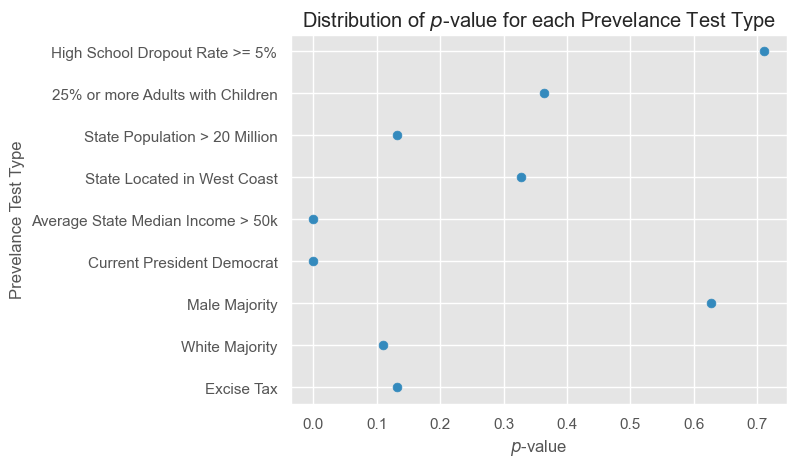

In [32]:
fig = plt.figure()

pval_df.plot.scatter(x='p_value', y='test_type',  colormap='viridis', s=40)

plt.title("Distribution of $p$-value for each Prevelance Test Type");
plt.xlabel('$p$-value');
plt.ylabel('Prevelance Test Type');

yticklabels = ['Excise Tax', 'White Majority', 'Male Majority',
               'Current President Democrat', 'Average State Median Income > 50k', 'State Located in West Coast',
               'State Population > 20 Million', '25% or more Adults with Children', 'High School Dropout Rate >= 5%']

plt.gca().set_yticklabels(yticklabels)

plt.show()

#### Suppose we use a naive p-value threshold of 0.05 to make a decision for each hypothesis test. Given the p-values from above, for which tests do we reject the null hypothesis?

In [33]:
pval_df[pval_df["p_value"] <= 0.05]

p_value                    test_type
3      0.0     president_dem_prevalence
4      0.0  income_above_50k_prevalence

#### Suppose we want to guarantee a Family-wise Error Rate (FWER) of 0.05. Given the p-values from above, for which tests do we reject the null hypothesis?

In [34]:
# Use Bonferroni to control for FWER
m = len(pval_df)
alpha = 0.05

pval_df[pval_df["p_value"] <= alpha/m]

p_value                    test_type
3      0.0     president_dem_prevalence
4      0.0  income_above_50k_prevalence

In [35]:
## Sanity check Bonferroni
x = statsmodels.stats.multitest.multipletests(pval_df["p_value"], alpha=0.05, method='bonferroni', 
                                         is_sorted=False, returnsorted=False)
pval_df[x[0]]

p_value                    test_type
3      0.0     president_dem_prevalence
4      0.0  income_above_50k_prevalence

#### Suppose we want to guarantee a False Discovery Rate (FDR) of 0.05. Given the p-values from above, for which tests do we reject the null hypothesis?

(Benjamini-Hochberg)

In [36]:
# Use Benjamini-Hochberg to control for FDR
sorted_df = pval_df.sort_values(by="p_value", ascending = True)
alpha = 0.05
m = len(sorted_df)  # number of tests

sorted_df["k"] = np.arange(1, m + 1)

# Find the threshold
sorted_df["below_threshold"] = sorted_df["p_value"] <= (sorted_df["k"] / m * alpha)
max_threshold = max(sorted_df[sorted_df["below_threshold"] == True]["p_value"])

# Filter
pval_df[pval_df["p_value"] <= max_threshold]

# 2 discoveries

p_value                    test_type
3      0.0     president_dem_prevalence
4      0.0  income_above_50k_prevalence

In [37]:
## Sanity check Benjamini
x = statsmodels.stats.multitest.multipletests(pval_df["p_value"], alpha=0.05, method='fdr_bh', 
                                         is_sorted=False, returnsorted=False)
pval_df[x[0]]

p_value                    test_type
3      0.0     president_dem_prevalence
4      0.0  income_above_50k_prevalence

#### Suppose we want to guarantee a False Discovery Rate (FDR) of 0.05. Given the p-values from above, for which tests do we reject the null hypothesis?

(Benjamini-Yekutieli)

In [38]:
# Benjamini–Yekutieli procedure
def harmonic_sum(n):
    if n < 2:
        return 1
    else:
        return 1 / n + (harmonic_sum(n - 1))

In [39]:
# Use Benjamini-Yekutieli to control for FDR
sorted_df = pval_df.sort_values(by="p_value", ascending = True)
alpha = 0.05
m = len(sorted_df)  # number of tests

sorted_df["k"] = np.arange(1, m + 1)

# Find the threshold
sorted_df["below_threshold"] = sorted_df["p_value"] <= (sorted_df["k"] / m * alpha/harmonic_sum(m))
max_threshold = max(sorted_df[sorted_df["below_threshold"] == True]["p_value"])

# Filter
pval_df[pval_df["p_value"] <= max_threshold]

# 2 discoveries

p_value                    test_type
3      0.0     president_dem_prevalence
4      0.0  income_above_50k_prevalence

In [40]:
## Sanity check Benjamini
x = statsmodels.stats.multitest.multipletests(pval_df["p_value"], alpha=0.05, method='fdr_by', 
                                         is_sorted=False, returnsorted=False)
pval_df[x[0]]

p_value                    test_type
3      0.0     president_dem_prevalence
4      0.0  income_above_50k_prevalence

Link: https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/
**Power Analysis:**
Statistical power is one piece in a puzzle that has four related parts; they are:

- Effect Size. 
    * The quantified magnitude of a result present in the population. 
    * Effect size is calculated using a specific statistical measure, such as Pearson’s correlation coefficient for the relationship between variables or Cohen’s d for the difference between groups.
- Sample Size. 
    * The number of observations in the sample.
- Significance. 
    * The significance level used in the statistical test, e.g. alpha. Often set to 5% or 0.05.
- Statistical Power. 
    * The probability of accepting the alternative hypothesis if it is true.
    
    
Based on this, let's use the above information to compute the power for our tests. 

We can use `statsmodels.stats.power.zt_ind_solve_power` which solves for power of a two sample/sided z-test. We can use this because A/B testing is a form of Z-test, and the function we are using works for z-tests.

#### Power For (1) Excise Tax & Prevalence Percent

In [41]:
random.seed(1234)
np.random.seed(1234)
pearson_coefficient, pearson_p_val = sc.stats.pearsonr(xdddf["excise_tax"], xdddf["prevalence_percent"])
pearson_coefficient

-0.13491603433704644

In [42]:
# https://statsthinking21.github.io/statsthinking21-python/09-StatisticalPower.html
random.seed(1234)
np.random.seed(1234)
smp.zt_ind_solve_power(effect_size=pearson_coefficient, nobs1=124,
                                           alpha=0.05, power=None, ratio=1.0, 
                                           alternative='two-sided')

0.18594466937898033

#### Power For (2) Race & Prevalence Percent

In [43]:
random.seed(1234)
np.random.seed(1234)
pearson_coefficient, pearson_p_val = sc.stats.pearsonr(xdddf["white_majority?"], xdddf["prevalence_percent"])
pearson_coefficient

0.14485760474309906

In [44]:
# https://statsthinking21.github.io/statsthinking21-python/09-StatisticalPower.html
random.seed(1234)
np.random.seed(1234)
smp.zt_ind_solve_power(effect_size=pearson_coefficient, nobs1=124,
                                           alpha=0.05, power=None, ratio=1.0, 
                                           alternative='two-sided')

0.20725794757143387

#### Power For (3) Gender & Prevalence Percent

In [45]:
random.seed(1234)
np.random.seed(1234)
pearson_coefficient, pearson_p_val = sc.stats.pearsonr(xdddf["male_majority?"], xdddf["prevalence_percent"])
pearson_coefficient

0.044180416041913154

In [46]:
# https://statsthinking21.github.io/statsthinking21-python/09-StatisticalPower.html
random.seed(1234)
np.random.seed(1234)
smp.zt_ind_solve_power(effect_size=pearson_coefficient, nobs1=124,
                                           alpha=0.05, power=None, ratio=1.0, 
                                           alternative='two-sided')

0.06397549296954808

#### Power For (4) U.S President & Prevalence Percent

In [47]:
random.seed(1234)
np.random.seed(1234)
pearson_coefficient, pearson_p_val = sc.stats.pearsonr(xdddf["president_dem?"], xdddf["prevalence_percent"])
pearson_coefficient

0.7054603647667006

In [48]:
# https://statsthinking21.github.io/statsthinking21-python/09-StatisticalPower.html
random.seed(1234)
np.random.seed(1234)
smp.zt_ind_solve_power(effect_size=pearson_coefficient, nobs1=124,
                                           alpha=0.05, power=None, ratio=1.0, 
                                           alternative='two-sided')

0.9998377023088798

#### Power For (5) Income & Prevalence Percent

In [49]:
random.seed(1234)
np.random.seed(1234)
pearson_coefficient, pearson_p_val = sc.stats.pearsonr(xdddf["income_above_50k"], xdddf["prevalence_percent"])
pearson_coefficient

-0.5654739107614282

In [50]:
# https://statsthinking21.github.io/statsthinking21-python/09-StatisticalPower.html
random.seed(1234)
np.random.seed(1234)
smp.zt_ind_solve_power(effect_size=pearson_coefficient, nobs1=124,
                                           alpha=0.05, power=None, ratio=1.0, 
                                           alternative='two-sided')

0.9936590986162979

#### Power For (6) West Coast & Prevalence Percent

In [51]:
random.seed(1234)
np.random.seed(1234)
pearson_coefficient, pearson_p_val = sc.stats.pearsonr(xdddf["West_Coast"], xdddf["prevalence_percent"])
pearson_coefficient

-0.0881485359973346

In [52]:
# https://statsthinking21.github.io/statsthinking21-python/09-StatisticalPower.html
random.seed(1234)
np.random.seed(1234)
smp.zt_ind_solve_power(effect_size=pearson_coefficient, nobs1=124,
                                           alpha=0.05, power=None, ratio=1.0, 
                                           alternative='two-sided')

0.10675436254592828

#### Power For (7) Population Above 20 Million & Prevalence Percent

In [53]:
random.seed(1234)
np.random.seed(1234)
pearson_coefficient, pearson_p_val = sc.stats.pearsonr(xdddf["prop_adults_with_children"], xdddf["prevalence_percent"])
pearson_coefficient

0.12021024851206183

In [54]:
# https://statsthinking21.github.io/statsthinking21-python/09-StatisticalPower.html
random.seed(1234)
np.random.seed(1234)
smp.zt_ind_solve_power(effect_size=pearson_coefficient, nobs1=124,
                                           alpha=0.05, power=None, ratio=1.0, 
                                           alternative='two-sided')

0.15725547691919395

#### Power For (8) More than 25% Adults with Children & Prevalence Percent

In [55]:
random.seed(1234)
np.random.seed(1234)
pearson_coefficient, pearson_p_val = sc.stats.pearsonr(xdddf["West_Coast"], xdddf["prevalence_percent"])
pearson_coefficient

-0.0881485359973346

In [56]:
# https://statsthinking21.github.io/statsthinking21-python/09-StatisticalPower.html
random.seed(1234)
np.random.seed(1234)
smp.zt_ind_solve_power(effect_size=pearson_coefficient, nobs1=124,
                                           alpha=0.05, power=None, ratio=1.0, 
                                           alternative='two-sided')

0.10675436254592828

#### Power For (9) HS dropout rate > 5% & Prevalence Percent

In [57]:
random.seed(1234)
np.random.seed(1234)
pearson_coefficient, pearson_p_val = sc.stats.pearsonr(xdddf["hs_dropout_rate"], xdddf["prevalence_percent"])
pearson_coefficient

-0.1704554833917968

In [58]:
# https://statsthinking21.github.io/statsthinking21-python/09-StatisticalPower.html
random.seed(1234)
np.random.seed(1234)
smp.zt_ind_solve_power(effect_size=pearson_coefficient, nobs1=124,
                                           alpha=0.05, power=None, ratio=1.0, 
                                           alternative='two-sided')

0.2688346203490895